In [1]:

import sqlite3
import pandas as pd
import numpy as np

from scipy.signal import savgol_filter


def trim_start_end_nans(df):
    """
    Removes rows at the start and end of a DataFrame that have NaN values in any column.
    """
    # Initialize start_idx and end_idx based on the DataFrame's index type
    if isinstance(df.index, pd.DatetimeIndex):
        start_idx = df.index[0]  # Assume first index is earliest; adjust if necessary
        end_idx = df.index[-1]  # Assume last index is latest; adjust if necessary
    else:
        start_idx = 0
        end_idx = len(df) - 1

    for column in df.columns:
        # Find the first non-NaN index in the current column
        first_valid_index = df[column].first_valid_index()
        if first_valid_index is not None and df.index.get_loc(first_valid_index) > df.index.get_loc(start_idx):
            start_idx = first_valid_index

        # Find the last non-NaN index in the current column
        last_valid_index = df[column].last_valid_index()
        if last_valid_index is not None and df.index.get_loc(last_valid_index) < df.index.get_loc(end_idx):
            end_idx = last_valid_index

    # Trim the DataFrame
    return df.loc[start_idx:end_idx]

# Now, apply the updated function to the DataFrame

def process_data_for_plot(plot_number, target_columns, continuous_columns, start_date='2023-07-20', end_date='2023-09-03'):
    """
    Process data for a given plot number within a specified date range.

    Parameters:
    - plot_number: The plot number to filter the data by.
    - start_date: The start date of the period to filter the data.
    - end_date: The end date of the period to filter the data.

    Returns:
    - A processed DataFrame with the data for the specified plot and date range.
    """
    # Connect to the database and load data
    conn = sqlite3.connect('processed_data.db')
    query = 'SELECT * from data_table'
    df = pd.read_sql_query(query, conn)
    conn.close()

    # Filter by plot_number
    df = df[df['plot_number'] == plot_number]
    
    # FILTER BY COLUMNS
    df = df[['TIMESTAMP'] + target_columns + continuous_columns]    

    # Filter by date range
    df = df[(df['TIMESTAMP'] >= start_date) & (df['TIMESTAMP'] <= end_date)]

    # Timestamp cyclical encoding
    df['TIMESTAMP'] = pd.to_datetime(df['TIMESTAMP'])
    df['day_sin'] = np.sin(df['TIMESTAMP'].dt.dayofyear / 365 * 2 * np.pi)
    df['day_cos'] = np.cos(df['TIMESTAMP'].dt.dayofyear / 365 * 2 * np.pi)
    df['dow_sin'] = np.sin(df['TIMESTAMP'].dt.dayofweek / 7 * 2 * np.pi)
    df['dow_cos'] = np.cos(df['TIMESTAMP'].dt.dayofweek / 7 * 2 * np.pi)


    # Eliminate duplicate indices and set TIMESTAMP as index
    df = df.drop_duplicates().set_index('TIMESTAMP').sort_index()
    
    # Resample to daily frequency
    df = df.resample('D').mean()

    # Assuming trim_start_end_nans is a predefined function to handle NaN values
    df = trim_start_end_nans(df)
    

    # Interpolate missing values
    df = df[target_columns + continuous_columns].interpolate(method='pchip')
    
        
    # testing different transforms
    df['precip_irrig_log'] = np.log(df['precip_irrig'] + 1)
    

    return df



In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from scipy.signal import savgol_filter
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Reshape, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1, l2 
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt
import keras
import json

# Check TensorFlow GPU availability
if tf.test.is_gpu_available(cuda_only=False, min_cuda_compute_capability=None):
    print("TensorFlow will use the GPU!")
else:
    print("TensorFlow cannot find a GPU!")



def subtract_mean(df, target_columns):
    mean_values = {}
    for col in target_columns:
        mean_value = df[col].mean()  
        df[col] -= mean_value
        mean_values[col] = mean_value
    return df, mean_values



def create_derivative_columns(df, target_columns, keep_original_cols=True):
    """Calculates difference-based derivatives of specified columns.

    Args:
        df: Pandas DataFrame containing the data.
        target_columns: List of columns for which derivatives are calculated.
        keep_original_cols: If True, creates new columns; otherwise overwrites.

    Returns:
        DataFrame with derivative columns, plus initial values if needed.
    """

    initial_values = {}  # Store initial values for reconstruction

    for col in target_columns:
        deriv_col_name = f"{col}_deriv"

        if keep_original_cols:
            df[deriv_col_name] = df[col].diff()  # Calculate differences
            
            #  #Plot the original and derived columns
            # plt.figure(figsize=(10, 6))
            # plt.plot(df[col], label=col)
            # plt.plot(df[deriv_col_name], label=deriv_col_name)
            # plt.xlabel('Time')
            # plt.ylabel('Value')
            # plt.title(f'{col} vs {deriv_col_name}')
            # plt.legend()
            # plt.show()
            
        else:
            initial_values[col] = df[col].iloc[0]  # Store initial value
            df[col] = df[col].diff()  
            

    return df, initial_values  # Return initial values as well

def scale_dataframe(df, scalers):
    """
    Optimally scale all columns in a DataFrame using MinMaxScaler, adjusting for an expanded range with a buffer. 
    This involves creating a dummy range for scaler fitting, then scaling the original data with the adjusted scaler.

    Args:
        df (pd.DataFrame): DataFrame with columns to be scaled.
        scalers (dict): Dictionary storing the scalers for each column.

    Returns:
        pd.DataFrame: Scaled DataFrame using the optimally adjusted scalers.
        dict: Dictionary of the adjusted scalers.
    """
    scaled_df = pd.DataFrame()  # Initialize an empty DataFrame for scaled values
    for column in df.columns:
        # Check if a scaler already exists; if not, proceed to create and fit a new one
        if column not in scalers:
            # Calculate the original range and apply a 30% buffer
            col_min, col_max = df[column].min(), df[column].max()
            range_buffer = (col_max - col_min) * 0.3  # 30% buffer
            buffered_min = col_min - range_buffer
            buffered_max = col_max + range_buffer

            # Create a new scaler and fit it on the buffered range
            scaler = MinMaxScaler(feature_range=(0, 1))
            scaler.fit([[buffered_min], [buffered_max]])
            scalers[column] = scaler

        # Scale the original data with the adjusted scaler
        scaled_values = scalers[column].transform(df[[column]].values.reshape(-1, 1)).flatten()  # Flatten the array here
        scaled_df[column] = scaled_values


    return scaled_df, scalers


def transform_and_scale_data(df, target_columns, scalers, keep_original_cols=True):
    """
    Transforms and scales the data in the DataFrame for neural network input, returning the
    transformed DataFrame, updated scalers, and transformation metadata.

    Args:
        df (pd.DataFrame): The input DataFrame.
        target_columns (list): List of target column names.
        scalers (dict): Dictionary containing MinMaxScalers for each column, can be empty.
        keep_original_cols (bool): If True, keeps original columns unchanged except for scaling;
                                   if False, applies transformations directly on the target columns.

    Returns:
        pd.DataFrame: The transformed and scaled DataFrame.
        dict: Updated dictionary containing MinMaxScalers for each column.
        dict: A dictionary containing transformation metadata for the target columns.
    """

    # Copy DataFrame to avoid modifying the original
    df_transformed = df.copy()

    
    # Subtract mean from target columns
    df_transformed, mean_values = subtract_mean(df_transformed, target_columns)
    
    # Apply transformations directly using helper functions
    df_transformed, initial_values = create_derivative_columns(df_transformed, target_columns, keep_original_cols)
    
    # Deleting or adjusting rows as necessary (e.g., due to NaN values from differentiation)
    df_transformed = df_transformed.iloc[1:]
    
    # Scale all columns in df_transformed
    df_transformed, scalers = scale_dataframe(df_transformed, scalers)
    
    print(f"Shape of transformed DataFrame: {df_transformed.shape}")
    
    # Metadata for reverse transformation
    transformation_metadata = {
        'means': mean_values,
        'scalers': scalers,
        'keep_original_cols': keep_original_cols,
        'initial_values': initial_values
    }
    
    # add 'precip_irrig_bool' as a binned column with 0 or 1
    df_transformed['precip_irrig_bool'] = df_transformed['precip_irrig_log'].apply(lambda x: 1 if x > 0 else 0)
    
    # Metadata for reverse transformation
    transformation_metadata = {
        'means': mean_values,
        'scalers': scalers,
        'keep_original_cols': keep_original_cols,
        'initial_values': initial_values,
        'columns': df.columns.tolist()
    }
    


    return df_transformed, transformation_metadata



def reverse_transform_and_scale_data(df, transformation_metadata, target_columns):
    """
    Reverses the transformations and scaling applied to the DataFrame.

    Args:
        df (pd.DataFrame): The transformed and scaled DataFrame.
        transformation_metadata (dict): A dictionary containing transformation metadata.
        target_columns (list): List of target columns to be reverse transformed and scaled.

    Returns:
        pd.DataFrame: The DataFrame with reversed transformations and scaling.
    """

    # Extract metadata
    scalers = transformation_metadata['scalers']
    mean_values = transformation_metadata['means']
    initial_values = transformation_metadata['initial_values']
    keep_original_cols = transformation_metadata['keep_original_cols']

    # Print dimensions of df
    print(f"Shape of input DataFrame: {df.shape}")

    # Reverse scale the target columns
    for column in target_columns:
        if column in scalers:
            # Reshape data for inverse_transform
            scaled_data = df[[column]].values
            # Apply inverse_transform
            df[column] = scalers[column].inverse_transform(scaled_data)

    # Apply undifferencing with cumsum() 
    for column in target_columns:
        # Reverse subtract mean from target columns if they were mean-adjusted
        if column in mean_values:
            print(f"Mean for {column}: ", mean_values[column])
            df[column] = df[column] + mean_values[column]
            print(f"Reversed mean for {column}: ", df[column].head())


    return df




# Sequence Creation Function
def create_sequences(input_data, target_data, input_window, forecast_horizon, stride=1):
    X, y = [], []
    for start in range(len(input_data) - input_window - forecast_horizon + stride):
        end = start + input_window
        X.append(input_data[start:end])
        y.append(target_data[end:end + forecast_horizon])
    return np.array(X), np.array(y)


def build_model(input_shape, num_targets):
    model = Sequential([
        LSTM(256, input_shape=input_shape, return_sequences=True, kernel_regularizer=l2(0.02)), 
        BatchNormalization(),
        Dropout(0.2),
        LSTM(128, return_sequences=True),  
        BatchNormalization(),
        Dropout(0.2),
        LSTM(64, return_sequences=True),  
        BatchNormalization(),
        Dropout(0.1),
        LSTM(64, return_sequences=True),  
        BatchNormalization(),
        Dropout(0.1),
        LSTM(32, return_sequences=False),
        Dense(4 * num_targets), 
        Reshape((4, num_targets)) 
    ])
    model.compile(optimizer='adam', loss='mse')
    return model




def chronological_split(X, y, test_size=0.2):
    # Calculate the index to split the data
    total_samples = len(X)
    split_index = int(total_samples * (1 - test_size))
    
    # Split the data chronologically
    X_train = X[:split_index]
    X_val = X[split_index:]
    y_train = y[:split_index]
    y_val = y[split_index:]
    
    return X_train, X_val, y_train, y_val

# Learning Rate Scheduler function
def scheduler(epoch, lr):
    if epoch < 15:
        return lr
    else:
        return lr * tf.math.exp(-0.1)


# Define the training step
@tf.function(reduce_retracing=True)
def train_step(model, optimizer, loss_function, x_batch, y_batch, epoch):
    with tf.GradientTape() as tape:
        predictions = model(x_batch, training=True)
        loss = loss_function(y_batch, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    # Update the learning rate correctly using TensorFlow operations
    lr = scheduler(epoch, optimizer.learning_rate)
    optimizer.learning_rate.assign(lr)
    return loss

# Define the validation step
@tf.function(reduce_retracing=True)
def val_step(model, loss_function, x_batch, y_batch):
    predictions = model(x_batch, training=False)
    loss = loss_function(y_batch, predictions)
    return loss

def run_workflow(
    training_data_transformed,
    target_variables,
    input_window,
    forecast_horizon,
    stride,
    epochs,
    batch_size,
    patience,
    checkpoint_path,
):
    X_train_all, X_val_all, y_train_all, y_val_all = [], [], [], []
    dataframe_identifiers = []
    n_splits =  5  # Define the number of splits for cross-validation

    # Data preparation
    for i, transformed_data in enumerate(training_data_transformed()):
        df = transformed_data[0]
        X, y = create_sequences(
            df.values,
            df[target_variables].values,
            input_window,
            forecast_horizon,
            stride,
        )
        tscv = TimeSeriesSplit(n_splits=n_splits)

        for fold, (train_index, val_index) in enumerate(tscv.split(X)):
            print(f"Processing fold {fold+1}/{n_splits} for DataFrame_{i}")
            X_train, X_val = X[train_index], X[val_index]
            y_train, y_val = y[train_index], y[val_index]

            X_train_all.append(X_train)
            X_val_all.append(X_val)
            y_train_all.append(y_train)
            y_val_all.append(y_val)

        dataframe_identifiers.append(f"DataFrame_{i}")

    # Model and training setup
    model = build_model((input_window, X_train_all[0].shape[2]), len(target_variables))
    initial_learning_rate =  0.001
    optimizer = tf.keras.optimizers.Adam(learning_rate=initial_learning_rate)
    loss_function = tf.keras.losses.MeanSquaredError()
    best_val_loss = np.inf

    # Training and validation
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        epoch_val_losses = []

        # Update learning rate using the scheduler function
        new_lr = scheduler(epoch, optimizer.learning_rate.numpy())
        optimizer.learning_rate.assign(new_lr)
        print(f"Current learning rate: {optimizer.learning_rate.numpy()}")

        for fold in range(n_splits):
            print(f"Training on fold {fold +  1}/{n_splits}")
            X_train, y_train = X_train_all[fold], y_train_all[fold]

            dataset = (
                tf.data.Dataset.from_tensor_slices((X_train, y_train))
                .batch(batch_size)
                .prefetch(tf.data.AUTOTUNE)
            )

            for x_batch, y_batch in dataset:
                train_step(model, optimizer, loss_function, x_batch, y_batch, epoch)

            # Validation
            X_val, y_val = X_val_all[fold], y_val_all[fold]
            val_dataset = (
                tf.data.Dataset.from_tensor_slices((X_val, y_val))
                .batch(batch_size)
                .prefetch(tf.data.AUTOTUNE)
            )
            val_losses = []
            for x_batch, y_batch in val_dataset:
                val_loss = val_step(model, loss_function, x_batch, y_batch)
                val_losses.append(val_loss.numpy())

            avg_val_loss = np.mean(val_losses)
            epoch_val_losses.append(avg_val_loss)
            print(f"Validation loss for fold {fold+1}/{n_splits}: {avg_val_loss}")

        # Average validation loss across folds
        average_val_loss = np.mean(epoch_val_losses)
        print(f"Average validation loss for epoch {epoch+1}: {average_val_loss}")

        # Early stopping and model saving logic
        if average_val_loss < best_val_loss:
            best_val_loss = average_val_loss
            model.save(checkpoint_path)
            print(
                f"Model saved at epoch {epoch+1} with validation loss: {average_val_loss}"
            )
            wait =  0  # Reset wait counter after improvement
        else:
            wait +=  1
            if wait >= patience:
                print(
                    f"Stopping early due to no improvement in validation loss for {patience} epochs."
                )
                break

    return checkpoint_path




# Example Usage
plot_numbers = [2014, 2015, 2007, 2001]


# Initialize a scaler
scalers = {}

# *** Important: Update the target_columns and continuous_columns based on your chosen target columns ***
# *** Any columns included in target_columns should be removed from continuous_columns ***
target_columns = ['VWC_06', 'VWC_18', 'VWC_30']
time_columns = ['day_sin', 'day_cos', 'hour_sin', 'hour_cos', 'dow_sin', 'dow_cos']
continuous_columns = [
    'Ta_2m_Avg', 'RH_2m_Avg', 'Solar_2m_Avg', 'WndAveSpd_3m', 'Rain_1m_Tot', 'Dp_2m_Avg',
    'TaMax_2m', 'TaMin_2m', 'RHMax_2m', 'RHMin_2m', 'HeatIndex_2m_Avg',
    'irrigation', 'precip_irrig','canopy_temp'
]
derivative_columns = ['precip_irrig']

input_window = 7
forecast_horizon = 4
stride = 1
epochs = 800
patience = 50
batch_size = 32  
checkpoint_path = "./LSTM_daily"



# Set to True to keep original columns unchanged
keep_original_cols=True


# Lambda function to handle training data and plot numbers
training_data_dfs = lambda: [process_data_for_plot(plot, target_columns=target_columns, continuous_columns=continuous_columns) for plot in plot_numbers]


# run once to get the transformation metadata
_, transformation_metadata = transform_and_scale_data(training_data_dfs()[0], target_columns, scalers, keep_original_cols)

# re-run with the transformation metadata for all training dataframes
training_data_transformed = lambda: [transform_and_scale_data(df, target_columns, transformation_metadata['scalers'], keep_original_cols) for df in training_data_dfs()]
   



# run the workflow for training the model
checkpoint_path = run_workflow(training_data_transformed, target_columns, 
                                      input_window, forecast_horizon, stride, epochs, batch_size, patience, checkpoint_path)

# run the workflow for training the model
import pickle

# Store the transformation metadata in checkpoint_path
with open(f"{checkpoint_path}/transformation_metadata_daily.pkl", "wb") as file:
    pickle.dump(transformation_metadata, file)




Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
TensorFlow cannot find a GPU!
Shape of transformed DataFrame: (44, 21)
Shape of transformed DataFrame: (44, 21)
Shape of transformed DataFrame: (44, 21)
Shape of transformed DataFrame: (44, 21)
Shape of transformed DataFrame: (44, 21)
Processing fold 1/5 for DataFrame_0
Processing fold 2/5 for DataFrame_0
Processing fold 3/5 for DataFrame_0
Processing fold 4/5 for DataFrame_0
Processing fold 5/5 for DataFrame_0
Processing fold 1/5 for DataFrame_1
Processing fold 2/5 for DataFrame_1
Processing fold 3/5 for DataFrame_1
Processing fold 4/5 for DataFrame_1
Processing fold 5/5 for DataFrame_1
Processing fold 1/5 for DataFrame_2
Processing fold 2/5 for DataFrame_2
Processing fold 3/5 for DataFrame_2
Processing fold 4/5 for DataFrame_2
Processing fold 5/5 for DataFrame_2
Processing fold 1/5 for DataFrame_3
Processing fold 2/5 for DataFrame_3
Processing fold 3/5 for DataFrame_3
Processing fold 4/5 for DataFrame_3


INFO:tensorflow:Assets written to: ./LSTM_daily\assets


Model saved at epoch 1 with validation loss: 0.3085559010505676
Epoch 2/800
Current learning rate: 0.0010000000474974513
Training on fold 1/5
Validation loss for fold 1/5: 0.46953287720680237
Training on fold 2/5
Validation loss for fold 2/5: 0.3308854103088379
Training on fold 3/5
Validation loss for fold 3/5: 0.26840412616729736
Training on fold 4/5
Validation loss for fold 4/5: 0.21115484833717346
Training on fold 5/5
Validation loss for fold 5/5: 0.15844598412513733
Average validation loss for epoch 2: 0.2876846194267273
INFO:tensorflow:Assets written to: ./LSTM_daily\assets


INFO:tensorflow:Assets written to: ./LSTM_daily\assets


Model saved at epoch 2 with validation loss: 0.2876846194267273
Epoch 3/800
Current learning rate: 0.0010000000474974513
Training on fold 1/5


Validation loss for fold 1/5: 0.44424551725387573
Training on fold 2/5


Validation loss for fold 2/5: 0.31043094396591187
Training on fold 3/5
Validation loss for fold 3/5: 0.24961146712303162
Training on fold 4/5
Validation loss for fold 4/5: 0.1947910487651825
Training on fold 5/5
Validation loss for fold 5/5: 0.1442366987466812
Average validation loss for epoch 3: 0.2686631381511688
INFO:tensorflow:Assets written to: ./LSTM_daily\assets


INFO:tensorflow:Assets written to: ./LSTM_daily\assets


Model saved at epoch 3 with validation loss: 0.2686631381511688
Epoch 4/800
Current learning rate: 0.0010000000474974513
Training on fold 1/5
Validation loss for fold 1/5: 0.4203033447265625
Training on fold 2/5
Validation loss for fold 2/5: 0.2910468280315399
Training on fold 3/5
Validation loss for fold 3/5: 0.23229432106018066
Training on fold 4/5
Validation loss for fold 4/5: 0.18021388351917267
Training on fold 5/5
Validation loss for fold 5/5: 0.13210368156433105
Average validation loss for epoch 4: 0.2511924207210541
INFO:tensorflow:Assets written to: ./LSTM_daily\assets


INFO:tensorflow:Assets written to: ./LSTM_daily\assets


Model saved at epoch 4 with validation loss: 0.2511924207210541
Epoch 5/800
Current learning rate: 0.0010000000474974513
Training on fold 1/5
Validation loss for fold 1/5: 0.39825060963630676
Training on fold 2/5
Validation loss for fold 2/5: 0.2736970782279968
Training on fold 3/5
Validation loss for fold 3/5: 0.21749000251293182
Training on fold 4/5
Validation loss for fold 4/5: 0.1678149402141571
Training on fold 5/5
Validation loss for fold 5/5: 0.12219379097223282
Average validation loss for epoch 5: 0.2358892858028412
INFO:tensorflow:Assets written to: ./LSTM_daily\assets


INFO:tensorflow:Assets written to: ./LSTM_daily\assets


Model saved at epoch 5 with validation loss: 0.2358892858028412
Epoch 6/800
Current learning rate: 0.0010000000474974513
Training on fold 1/5
Validation loss for fold 1/5: 0.37847957015037537
Training on fold 2/5
Validation loss for fold 2/5: 0.2577856183052063
Training on fold 3/5
Validation loss for fold 3/5: 0.2041015923023224
Training on fold 4/5
Validation loss for fold 4/5: 0.15703460574150085
Training on fold 5/5
Validation loss for fold 5/5: 0.11402013152837753
Average validation loss for epoch 6: 0.22228428721427917
INFO:tensorflow:Assets written to: ./LSTM_daily\assets


INFO:tensorflow:Assets written to: ./LSTM_daily\assets


Model saved at epoch 6 with validation loss: 0.22228428721427917
Epoch 7/800
Current learning rate: 0.0010000000474974513
Training on fold 1/5
Validation loss for fold 1/5: 0.36114034056663513
Training on fold 2/5
Validation loss for fold 2/5: 0.244279146194458
Training on fold 3/5
Validation loss for fold 3/5: 0.1934964954853058
Training on fold 4/5
Validation loss for fold 4/5: 0.14919345080852509
Training on fold 5/5
Validation loss for fold 5/5: 0.10854285955429077
Average validation loss for epoch 7: 0.21133045852184296
INFO:tensorflow:Assets written to: ./LSTM_daily\assets


INFO:tensorflow:Assets written to: ./LSTM_daily\assets


Model saved at epoch 7 with validation loss: 0.21133045852184296
Epoch 8/800
Current learning rate: 0.0010000000474974513
Training on fold 1/5
Validation loss for fold 1/5: 0.3482259511947632
Training on fold 2/5
Validation loss for fold 2/5: 0.234354168176651
Training on fold 3/5
Validation loss for fold 3/5: 0.18572300672531128
Training on fold 4/5
Validation loss for fold 4/5: 0.1436155140399933
Training on fold 5/5
Validation loss for fold 5/5: 0.10444359481334686
Average validation loss for epoch 8: 0.20327243208885193
INFO:tensorflow:Assets written to: ./LSTM_daily\assets


INFO:tensorflow:Assets written to: ./LSTM_daily\assets


Model saved at epoch 8 with validation loss: 0.20327243208885193
Epoch 9/800
Current learning rate: 0.0010000000474974513
Training on fold 1/5
Validation loss for fold 1/5: 0.33750098943710327
Training on fold 2/5
Validation loss for fold 2/5: 0.22581450641155243
Training on fold 3/5
Validation loss for fold 3/5: 0.17934970557689667
Training on fold 4/5
Validation loss for fold 4/5: 0.13901600241661072
Training on fold 5/5
Validation loss for fold 5/5: 0.1014958843588829
Average validation loss for epoch 9: 0.1966354101896286
INFO:tensorflow:Assets written to: ./LSTM_daily\assets


INFO:tensorflow:Assets written to: ./LSTM_daily\assets


Model saved at epoch 9 with validation loss: 0.1966354101896286
Epoch 10/800
Current learning rate: 0.0010000000474974513
Training on fold 1/5
Validation loss for fold 1/5: 0.3286476731300354
Training on fold 2/5
Validation loss for fold 2/5: 0.21940135955810547
Training on fold 3/5
Validation loss for fold 3/5: 0.17554154992103577
Training on fold 4/5
Validation loss for fold 4/5: 0.13673929870128632
Training on fold 5/5
Validation loss for fold 5/5: 0.10012297332286835
Average validation loss for epoch 10: 0.19209058582782745
INFO:tensorflow:Assets written to: ./LSTM_daily\assets


INFO:tensorflow:Assets written to: ./LSTM_daily\assets


Model saved at epoch 10 with validation loss: 0.19209058582782745
Epoch 11/800
Current learning rate: 0.0010000000474974513
Training on fold 1/5
Validation loss for fold 1/5: 0.32363784313201904
Training on fold 2/5
Validation loss for fold 2/5: 0.21577079594135284
Training on fold 3/5
Validation loss for fold 3/5: 0.1728721261024475
Training on fold 4/5
Validation loss for fold 4/5: 0.13488587737083435
Training on fold 5/5
Validation loss for fold 5/5: 0.09851355850696564
Average validation loss for epoch 11: 0.18913604319095612
INFO:tensorflow:Assets written to: ./LSTM_daily\assets


INFO:tensorflow:Assets written to: ./LSTM_daily\assets


Model saved at epoch 11 with validation loss: 0.18913604319095612
Epoch 12/800
Current learning rate: 0.0010000000474974513
Training on fold 1/5
Validation loss for fold 1/5: 0.3178485333919525
Training on fold 2/5
Validation loss for fold 2/5: 0.21123437583446503
Training on fold 3/5
Validation loss for fold 3/5: 0.16978490352630615
Training on fold 4/5
Validation loss for fold 4/5: 0.13278992474079132
Training on fold 5/5
Validation loss for fold 5/5: 0.09703527390956879
Average validation loss for epoch 12: 0.18573859333992004
INFO:tensorflow:Assets written to: ./LSTM_daily\assets


INFO:tensorflow:Assets written to: ./LSTM_daily\assets


Model saved at epoch 12 with validation loss: 0.18573859333992004
Epoch 13/800
Current learning rate: 0.0010000000474974513
Training on fold 1/5
Validation loss for fold 1/5: 0.3127468526363373
Training on fold 2/5
Validation loss for fold 2/5: 0.20799770951271057
Training on fold 3/5
Validation loss for fold 3/5: 0.16801218688488007
Training on fold 4/5
Validation loss for fold 4/5: 0.1319093257188797
Training on fold 5/5
Validation loss for fold 5/5: 0.09635218232870102
Average validation loss for epoch 13: 0.1834036409854889
INFO:tensorflow:Assets written to: ./LSTM_daily\assets


INFO:tensorflow:Assets written to: ./LSTM_daily\assets


Model saved at epoch 13 with validation loss: 0.1834036409854889
Epoch 14/800
Current learning rate: 0.0010000000474974513
Training on fold 1/5
Validation loss for fold 1/5: 0.3094039559364319
Training on fold 2/5
Validation loss for fold 2/5: 0.20624980330467224
Training on fold 3/5
Validation loss for fold 3/5: 0.16685588657855988
Training on fold 4/5
Validation loss for fold 4/5: 0.13111861050128937
Training on fold 5/5
Validation loss for fold 5/5: 0.09522666037082672
Average validation loss for epoch 14: 0.18177096545696259
INFO:tensorflow:Assets written to: ./LSTM_daily\assets


INFO:tensorflow:Assets written to: ./LSTM_daily\assets


Model saved at epoch 14 with validation loss: 0.18177096545696259
Epoch 15/800
Current learning rate: 0.0010000000474974513
Training on fold 1/5
Validation loss for fold 1/5: 0.3059367537498474
Training on fold 2/5
Validation loss for fold 2/5: 0.20369644463062286
Training on fold 3/5
Validation loss for fold 3/5: 0.16455194354057312
Training on fold 4/5
Validation loss for fold 4/5: 0.12954464554786682
Training on fold 5/5
Validation loss for fold 5/5: 0.09406113624572754
Average validation loss for epoch 15: 0.1795581877231598
INFO:tensorflow:Assets written to: ./LSTM_daily\assets


INFO:tensorflow:Assets written to: ./LSTM_daily\assets


Model saved at epoch 15 with validation loss: 0.1795581877231598
Epoch 16/800
Current learning rate: 0.0009048374486155808
Training on fold 1/5
Validation loss for fold 1/5: 0.30180779099464417
Training on fold 2/5
Validation loss for fold 2/5: 0.2000531256198883
Training on fold 3/5
Validation loss for fold 3/5: 0.1620846837759018
Training on fold 4/5
Validation loss for fold 4/5: 0.12826326489448547
Training on fold 5/5
Validation loss for fold 5/5: 0.09349186718463898
Average validation loss for epoch 16: 0.17714014649391174
INFO:tensorflow:Assets written to: ./LSTM_daily\assets


INFO:tensorflow:Assets written to: ./LSTM_daily\assets


Model saved at epoch 16 with validation loss: 0.17714014649391174
Epoch 17/800
Current learning rate: 0.0004965853877365589
Training on fold 1/5
Validation loss for fold 1/5: 0.29781192541122437
Training on fold 2/5
Validation loss for fold 2/5: 0.19704844057559967
Training on fold 3/5
Validation loss for fold 3/5: 0.16020740568637848
Training on fold 4/5
Validation loss for fold 4/5: 0.12734034657478333
Training on fold 5/5
Validation loss for fold 5/5: 0.09283732622861862
Average validation loss for epoch 17: 0.1750490963459015
INFO:tensorflow:Assets written to: ./LSTM_daily\assets


INFO:tensorflow:Assets written to: ./LSTM_daily\assets


Model saved at epoch 17 with validation loss: 0.1750490963459015
Epoch 18/800
Current learning rate: 0.0002725318481680006
Training on fold 1/5
Validation loss for fold 1/5: 0.29389023780822754
Training on fold 2/5
Validation loss for fold 2/5: 0.19404646754264832
Training on fold 3/5
Validation loss for fold 3/5: 0.15847042202949524
Training on fold 4/5
Validation loss for fold 4/5: 0.1264847368001938
Training on fold 5/5
Validation loss for fold 5/5: 0.09204583615064621
Average validation loss for epoch 18: 0.17298755049705505
INFO:tensorflow:Assets written to: ./LSTM_daily\assets


INFO:tensorflow:Assets written to: ./LSTM_daily\assets


Model saved at epoch 18 with validation loss: 0.17298755049705505
Epoch 19/800
Current learning rate: 0.00014956865925341845
Training on fold 1/5
Validation loss for fold 1/5: 0.29003995656967163
Training on fold 2/5
Validation loss for fold 2/5: 0.19146034121513367
Training on fold 3/5
Validation loss for fold 3/5: 0.156997948884964
Training on fold 4/5
Validation loss for fold 4/5: 0.12576475739479065
Training on fold 5/5
Validation loss for fold 5/5: 0.09129834175109863
Average validation loss for epoch 19: 0.1711122691631317
INFO:tensorflow:Assets written to: ./LSTM_daily\assets


INFO:tensorflow:Assets written to: ./LSTM_daily\assets


Model saved at epoch 19 with validation loss: 0.1711122691631317
Epoch 20/800
Current learning rate: 8.208502549678087e-05
Training on fold 1/5
Validation loss for fold 1/5: 0.2866762578487396
Training on fold 2/5
Validation loss for fold 2/5: 0.18926368653774261
Training on fold 3/5
Validation loss for fold 3/5: 0.1557116061449051
Training on fold 4/5
Validation loss for fold 4/5: 0.1252051591873169
Training on fold 5/5
Validation loss for fold 5/5: 0.09065569937229156
Average validation loss for epoch 20: 0.16950246691703796
INFO:tensorflow:Assets written to: ./LSTM_daily\assets


INFO:tensorflow:Assets written to: ./LSTM_daily\assets


Model saved at epoch 20 with validation loss: 0.16950246691703796
Epoch 21/800
Current learning rate: 4.504921889747493e-05
Training on fold 1/5
Validation loss for fold 1/5: 0.2834872603416443
Training on fold 2/5
Validation loss for fold 2/5: 0.1870674192905426
Training on fold 3/5
Validation loss for fold 3/5: 0.15449687838554382
Training on fold 4/5
Validation loss for fold 4/5: 0.12469255924224854
Training on fold 5/5
Validation loss for fold 5/5: 0.08997330814599991
Average validation loss for epoch 21: 0.16794349253177643
INFO:tensorflow:Assets written to: ./LSTM_daily\assets


INFO:tensorflow:Assets written to: ./LSTM_daily\assets


Model saved at epoch 21 with validation loss: 0.16794349253177643
Epoch 22/800
Current learning rate: 2.4723536625970155e-05
Training on fold 1/5
Validation loss for fold 1/5: 0.280348539352417
Training on fold 2/5
Validation loss for fold 2/5: 0.184831440448761
Training on fold 3/5
Validation loss for fold 3/5: 0.1533118039369583
Training on fold 4/5
Validation loss for fold 4/5: 0.12424547970294952
Training on fold 5/5
Validation loss for fold 5/5: 0.08939584344625473
Average validation loss for epoch 22: 0.1664266139268875
INFO:tensorflow:Assets written to: ./LSTM_daily\assets


INFO:tensorflow:Assets written to: ./LSTM_daily\assets


Model saved at epoch 22 with validation loss: 0.1664266139268875
Epoch 23/800
Current learning rate: 1.3568564099841751e-05
Training on fold 1/5
Validation loss for fold 1/5: 0.2773129343986511
Training on fold 2/5
Validation loss for fold 2/5: 0.18273204565048218
Training on fold 3/5
Validation loss for fold 3/5: 0.15230603516101837
Training on fold 4/5
Validation loss for fold 4/5: 0.1239374428987503
Training on fold 5/5
Validation loss for fold 5/5: 0.08885518461465836
Average validation loss for epoch 23: 0.16502872109413147
INFO:tensorflow:Assets written to: ./LSTM_daily\assets


INFO:tensorflow:Assets written to: ./LSTM_daily\assets


Model saved at epoch 23 with validation loss: 0.16502872109413147
Epoch 24/800
Current learning rate: 7.4465860961936414e-06
Training on fold 1/5
Validation loss for fold 1/5: 0.2745768427848816
Training on fold 2/5
Validation loss for fold 2/5: 0.1806296706199646
Training on fold 3/5
Validation loss for fold 3/5: 0.15116941928863525
Training on fold 4/5
Validation loss for fold 4/5: 0.12353329360485077
Training on fold 5/5
Validation loss for fold 5/5: 0.0881495252251625
Average validation loss for epoch 24: 0.1636117547750473
INFO:tensorflow:Assets written to: ./LSTM_daily\assets


INFO:tensorflow:Assets written to: ./LSTM_daily\assets


Model saved at epoch 24 with validation loss: 0.1636117547750473
Epoch 25/800
Current learning rate: 4.086773515155073e-06
Training on fold 1/5
Validation loss for fold 1/5: 0.2716390788555145
Training on fold 2/5
Validation loss for fold 2/5: 0.17845836281776428
Training on fold 3/5
Validation loss for fold 3/5: 0.15019014477729797
Training on fold 4/5
Validation loss for fold 4/5: 0.12319954484701157
Training on fold 5/5
Validation loss for fold 5/5: 0.08749574422836304
Average validation loss for epoch 25: 0.1621965616941452
INFO:tensorflow:Assets written to: ./LSTM_daily\assets


INFO:tensorflow:Assets written to: ./LSTM_daily\assets


Model saved at epoch 25 with validation loss: 0.1621965616941452
Epoch 26/800
Current learning rate: 2.2428689590014983e-06
Training on fold 1/5
Validation loss for fold 1/5: 0.26896780729293823
Training on fold 2/5
Validation loss for fold 2/5: 0.17652808129787445
Training on fold 3/5
Validation loss for fold 3/5: 0.14925648272037506
Training on fold 4/5
Validation loss for fold 4/5: 0.12291309982538223
Training on fold 5/5
Validation loss for fold 5/5: 0.08683369308710098
Average validation loss for epoch 26: 0.16089984774589539
INFO:tensorflow:Assets written to: ./LSTM_daily\assets


INFO:tensorflow:Assets written to: ./LSTM_daily\assets


Model saved at epoch 26 with validation loss: 0.16089984774589539
Epoch 27/800
Current learning rate: 1.2309125168030732e-06
Training on fold 1/5
Validation loss for fold 1/5: 0.2663528323173523
Training on fold 2/5
Validation loss for fold 2/5: 0.1745443046092987
Training on fold 3/5
Validation loss for fold 3/5: 0.14848226308822632
Training on fold 4/5
Validation loss for fold 4/5: 0.12276019155979156
Training on fold 5/5
Validation loss for fold 5/5: 0.0861981064081192
Average validation loss for epoch 27: 0.15966753661632538
INFO:tensorflow:Assets written to: ./LSTM_daily\assets


INFO:tensorflow:Assets written to: ./LSTM_daily\assets


Model saved at epoch 27 with validation loss: 0.15966753661632538
Epoch 28/800
Current learning rate: 6.755391837032221e-07
Training on fold 1/5
Validation loss for fold 1/5: 0.2639685273170471
Training on fold 2/5
Validation loss for fold 2/5: 0.17263060808181763
Training on fold 3/5
Validation loss for fold 3/5: 0.14764823019504547
Training on fold 4/5
Validation loss for fold 4/5: 0.12253668159246445
Training on fold 5/5
Validation loss for fold 5/5: 0.08547432720661163
Average validation loss for epoch 28: 0.15845166146755219
INFO:tensorflow:Assets written to: ./LSTM_daily\assets


INFO:tensorflow:Assets written to: ./LSTM_daily\assets


Model saved at epoch 28 with validation loss: 0.15845166146755219
Epoch 29/800
Current learning rate: 3.7074377701173944e-07
Training on fold 1/5
Validation loss for fold 1/5: 0.26148802042007446
Training on fold 2/5
Validation loss for fold 2/5: 0.17079555988311768
Training on fold 3/5
Validation loss for fold 3/5: 0.14705678820610046
Training on fold 4/5
Validation loss for fold 4/5: 0.12244713306427002
Training on fold 5/5
Validation loss for fold 5/5: 0.08476518839597702
Average validation loss for epoch 29: 0.15731053054332733
INFO:tensorflow:Assets written to: ./LSTM_daily\assets


INFO:tensorflow:Assets written to: ./LSTM_daily\assets


Model saved at epoch 29 with validation loss: 0.15731053054332733
Epoch 30/800
Current learning rate: 2.0346851670183241e-07
Training on fold 1/5
Validation loss for fold 1/5: 0.25925835967063904
Training on fold 2/5
Validation loss for fold 2/5: 0.1689096987247467
Training on fold 3/5
Validation loss for fold 3/5: 0.14632992446422577
Training on fold 4/5
Validation loss for fold 4/5: 0.12229840457439423
Training on fold 5/5
Validation loss for fold 5/5: 0.08400245010852814
Average validation loss for epoch 30: 0.15615977346897125
INFO:tensorflow:Assets written to: ./LSTM_daily\assets


INFO:tensorflow:Assets written to: ./LSTM_daily\assets


Model saved at epoch 30 with validation loss: 0.15615977346897125
Epoch 31/800
Current learning rate: 1.1166589786171244e-07
Training on fold 1/5
Validation loss for fold 1/5: 0.256796658039093
Training on fold 2/5
Validation loss for fold 2/5: 0.16702581942081451
Training on fold 3/5
Validation loss for fold 3/5: 0.14572863280773163
Training on fold 4/5
Validation loss for fold 4/5: 0.12217690795660019
Training on fold 5/5
Validation loss for fold 5/5: 0.08320099860429764
Average validation loss for epoch 31: 0.15498580038547516
INFO:tensorflow:Assets written to: ./LSTM_daily\assets


INFO:tensorflow:Assets written to: ./LSTM_daily\assets


Model saved at epoch 31 with validation loss: 0.15498580038547516
Epoch 32/800
Current learning rate: 6.128355067858138e-08
Training on fold 1/5
Validation loss for fold 1/5: 0.25467047095298767
Training on fold 2/5
Validation loss for fold 2/5: 0.1651337444782257
Training on fold 3/5
Validation loss for fold 3/5: 0.1452789008617401
Training on fold 4/5
Validation loss for fold 4/5: 0.12217415869235992
Training on fold 5/5
Validation loss for fold 5/5: 0.08238371461629868
Average validation loss for epoch 32: 0.15392819046974182
INFO:tensorflow:Assets written to: ./LSTM_daily\assets


INFO:tensorflow:Assets written to: ./LSTM_daily\assets


Model saved at epoch 32 with validation loss: 0.15392819046974182
Epoch 33/800
Current learning rate: 3.363313183513128e-08
Training on fold 1/5
Validation loss for fold 1/5: 0.2526071071624756
Training on fold 2/5
Validation loss for fold 2/5: 0.163481205701828
Training on fold 3/5
Validation loss for fold 3/5: 0.14486613869667053
Training on fold 4/5
Validation loss for fold 4/5: 0.12217654287815094
Training on fold 5/5
Validation loss for fold 5/5: 0.08152185380458832
Average validation loss for epoch 33: 0.15293057262897491
INFO:tensorflow:Assets written to: ./LSTM_daily\assets


INFO:tensorflow:Assets written to: ./LSTM_daily\assets


Model saved at epoch 33 with validation loss: 0.15293057262897491
Epoch 34/800
Current learning rate: 1.8458255368614118e-08
Training on fold 1/5
Validation loss for fold 1/5: 0.2506684958934784
Training on fold 2/5
Validation loss for fold 2/5: 0.16169437766075134
Training on fold 3/5
Validation loss for fold 3/5: 0.14450201392173767
Training on fold 4/5
Validation loss for fold 4/5: 0.12219605594873428
Training on fold 5/5
Validation loss for fold 5/5: 0.08057855814695358
Average validation loss for epoch 34: 0.1519279032945633
INFO:tensorflow:Assets written to: ./LSTM_daily\assets


INFO:tensorflow:Assets written to: ./LSTM_daily\assets


Model saved at epoch 34 with validation loss: 0.1519279032945633
Epoch 35/800
Current learning rate: 1.0130106531391903e-08
Training on fold 1/5
Validation loss for fold 1/5: 0.2486775815486908
Training on fold 2/5
Validation loss for fold 2/5: 0.1600784808397293
Training on fold 3/5
Validation loss for fold 3/5: 0.14426277577877045
Training on fold 4/5
Validation loss for fold 4/5: 0.1222149133682251
Training on fold 5/5
Validation loss for fold 5/5: 0.07958461344242096
Average validation loss for epoch 35: 0.1509636789560318
INFO:tensorflow:Assets written to: ./LSTM_daily\assets


INFO:tensorflow:Assets written to: ./LSTM_daily\assets


Model saved at epoch 35 with validation loss: 0.1509636789560318
Epoch 36/800
Current learning rate: 5.5595212877790345e-09
Training on fold 1/5
Validation loss for fold 1/5: 0.24672777950763702
Training on fold 2/5
Validation loss for fold 2/5: 0.158152773976326
Training on fold 3/5
Validation loss for fold 3/5: 0.1438620537519455
Training on fold 4/5
Validation loss for fold 4/5: 0.12217648327350616
Training on fold 5/5
Validation loss for fold 5/5: 0.07853947579860687
Average validation loss for epoch 36: 0.1498917043209076
INFO:tensorflow:Assets written to: ./LSTM_daily\assets


INFO:tensorflow:Assets written to: ./LSTM_daily\assets


Model saved at epoch 36 with validation loss: 0.1498917043209076
Epoch 37/800
Current learning rate: 3.051130237352595e-09
Training on fold 1/5
Validation loss for fold 1/5: 0.24449357390403748
Training on fold 2/5
Validation loss for fold 2/5: 0.15624211728572845
Training on fold 3/5
Validation loss for fold 3/5: 0.1435219794511795
Training on fold 4/5
Validation loss for fold 4/5: 0.12207198143005371
Training on fold 5/5
Validation loss for fold 5/5: 0.0773262232542038
Average validation loss for epoch 37: 0.14873117208480835
INFO:tensorflow:Assets written to: ./LSTM_daily\assets


INFO:tensorflow:Assets written to: ./LSTM_daily\assets


Model saved at epoch 37 with validation loss: 0.14873117208480835
Epoch 38/800
Current learning rate: 1.6744959863146391e-09
Training on fold 1/5
Validation loss for fold 1/5: 0.24246224761009216
Training on fold 2/5
Validation loss for fold 2/5: 0.15421931445598602
Training on fold 3/5
Validation loss for fold 3/5: 0.14311978220939636
Training on fold 4/5
Validation loss for fold 4/5: 0.12202994525432587
Training on fold 5/5
Validation loss for fold 5/5: 0.07623361796140671
Average validation loss for epoch 38: 0.14761298894882202
INFO:tensorflow:Assets written to: ./LSTM_daily\assets


INFO:tensorflow:Assets written to: ./LSTM_daily\assets


Model saved at epoch 38 with validation loss: 0.14761298894882202
Epoch 39/800
Current learning rate: 9.189830008082822e-10
Training on fold 1/5
Validation loss for fold 1/5: 0.24023108184337616
Training on fold 2/5
Validation loss for fold 2/5: 0.15232530236244202
Training on fold 3/5
Validation loss for fold 3/5: 0.14284206926822662
Training on fold 4/5
Validation loss for fold 4/5: 0.12193010002374649
Training on fold 5/5
Validation loss for fold 5/5: 0.07489534467458725
Average validation loss for epoch 39: 0.14644476771354675
INFO:tensorflow:Assets written to: ./LSTM_daily\assets


INFO:tensorflow:Assets written to: ./LSTM_daily\assets


Model saved at epoch 39 with validation loss: 0.14644476771354675
Epoch 40/800
Current learning rate: 5.043486184241885e-10
Training on fold 1/5
Validation loss for fold 1/5: 0.23823051154613495
Training on fold 2/5
Validation loss for fold 2/5: 0.15044990181922913
Training on fold 3/5
Validation loss for fold 3/5: 0.14257417619228363
Training on fold 4/5
Validation loss for fold 4/5: 0.1218334212899208
Training on fold 5/5
Validation loss for fold 5/5: 0.07357172667980194
Average validation loss for epoch 40: 0.1453319489955902
INFO:tensorflow:Assets written to: ./LSTM_daily\assets


INFO:tensorflow:Assets written to: ./LSTM_daily\assets


Model saved at epoch 40 with validation loss: 0.1453319489955902
Epoch 41/800
Current learning rate: 2.767923945601325e-10
Training on fold 1/5
Validation loss for fold 1/5: 0.23620815575122833
Training on fold 2/5
Validation loss for fold 2/5: 0.14843113720417023
Training on fold 3/5
Validation loss for fold 3/5: 0.1422620713710785
Training on fold 4/5
Validation loss for fold 4/5: 0.12184397876262665
Training on fold 5/5
Validation loss for fold 5/5: 0.0723385214805603
Average validation loss for epoch 41: 0.14421677589416504
INFO:tensorflow:Assets written to: ./LSTM_daily\assets


INFO:tensorflow:Assets written to: ./LSTM_daily\assets


Model saved at epoch 41 with validation loss: 0.14421677589416504
Epoch 42/800
Current learning rate: 1.519068898447884e-10
Training on fold 1/5
Validation loss for fold 1/5: 0.23415496945381165
Training on fold 2/5
Validation loss for fold 2/5: 0.14596609771251678
Training on fold 3/5
Validation loss for fold 3/5: 0.14191311597824097
Training on fold 4/5
Validation loss for fold 4/5: 0.1217464953660965
Training on fold 5/5
Validation loss for fold 5/5: 0.07107522338628769
Average validation loss for epoch 42: 0.14297117292881012
INFO:tensorflow:Assets written to: ./LSTM_daily\assets


INFO:tensorflow:Assets written to: ./LSTM_daily\assets


Model saved at epoch 42 with validation loss: 0.14297117292881012
Epoch 43/800
Current learning rate: 8.336827755917042e-11
Training on fold 1/5
Validation loss for fold 1/5: 0.23175406455993652
Training on fold 2/5
Validation loss for fold 2/5: 0.1432267129421234
Training on fold 3/5
Validation loss for fold 3/5: 0.1413562297821045
Training on fold 4/5
Validation loss for fold 4/5: 0.12154990434646606
Training on fold 5/5
Validation loss for fold 5/5: 0.06979572027921677
Average validation loss for epoch 43: 0.14153653383255005
INFO:tensorflow:Assets written to: ./LSTM_daily\assets


INFO:tensorflow:Assets written to: ./LSTM_daily\assets


Model saved at epoch 43 with validation loss: 0.14153653383255005
Epoch 44/800
Current learning rate: 4.575348086510722e-11
Training on fold 1/5
Validation loss for fold 1/5: 0.229421466588974
Training on fold 2/5
Validation loss for fold 2/5: 0.14056512713432312
Training on fold 3/5
Validation loss for fold 3/5: 0.14102301001548767
Training on fold 4/5
Validation loss for fold 4/5: 0.121542789041996
Training on fold 5/5
Validation loss for fold 5/5: 0.06852175295352936
Average validation loss for epoch 44: 0.14021483063697815
INFO:tensorflow:Assets written to: ./LSTM_daily\assets


INFO:tensorflow:Assets written to: ./LSTM_daily\assets


Model saved at epoch 44 with validation loss: 0.14021483063697815
Epoch 45/800
Current learning rate: 2.511004598693134e-11
Training on fold 1/5
Validation loss for fold 1/5: 0.22705033421516418
Training on fold 2/5
Validation loss for fold 2/5: 0.13778670132160187
Training on fold 3/5
Validation loss for fold 3/5: 0.14044499397277832
Training on fold 4/5
Validation loss for fold 4/5: 0.12130963802337646
Training on fold 5/5
Validation loss for fold 5/5: 0.06705107539892197
Average validation loss for epoch 45: 0.1387285441160202
INFO:tensorflow:Assets written to: ./LSTM_daily\assets


INFO:tensorflow:Assets written to: ./LSTM_daily\assets


Model saved at epoch 45 with validation loss: 0.1387285441160202
Epoch 46/800
Current learning rate: 1.3780685793884917e-11
Training on fold 1/5
Validation loss for fold 1/5: 0.22473497688770294
Training on fold 2/5
Validation loss for fold 2/5: 0.13481947779655457
Training on fold 3/5
Validation loss for fold 3/5: 0.13971486687660217
Training on fold 4/5
Validation loss for fold 4/5: 0.12101660668849945
Training on fold 5/5
Validation loss for fold 5/5: 0.06552445888519287
Average validation loss for epoch 46: 0.13716207444667816
INFO:tensorflow:Assets written to: ./LSTM_daily\assets


INFO:tensorflow:Assets written to: ./LSTM_daily\assets


Model saved at epoch 46 with validation loss: 0.13716207444667816
Epoch 47/800
Current learning rate: 7.563000573029832e-12
Training on fold 1/5
Validation loss for fold 1/5: 0.22231069207191467
Training on fold 2/5
Validation loss for fold 2/5: 0.13165001571178436
Training on fold 3/5
Validation loss for fold 3/5: 0.13907209038734436
Training on fold 4/5
Validation loss for fold 4/5: 0.1208166629076004
Training on fold 5/5
Validation loss for fold 5/5: 0.06404107809066772
Average validation loss for epoch 47: 0.13557811081409454
INFO:tensorflow:Assets written to: ./LSTM_daily\assets


INFO:tensorflow:Assets written to: ./LSTM_daily\assets


Model saved at epoch 47 with validation loss: 0.13557811081409454
Epoch 48/800
Current learning rate: 4.1506628863097195e-12
Training on fold 1/5
Validation loss for fold 1/5: 0.21978023648262024
Training on fold 2/5
Validation loss for fold 2/5: 0.12831620872020721
Training on fold 3/5
Validation loss for fold 3/5: 0.13842186331748962
Training on fold 4/5
Validation loss for fold 4/5: 0.12057684361934662
Training on fold 5/5
Validation loss for fold 5/5: 0.0625167042016983
Average validation loss for epoch 48: 0.13392236828804016
INFO:tensorflow:Assets written to: ./LSTM_daily\assets


INFO:tensorflow:Assets written to: ./LSTM_daily\assets


Model saved at epoch 48 with validation loss: 0.13392236828804016
Epoch 49/800
Current learning rate: 2.2779321831589705e-12
Training on fold 1/5
Validation loss for fold 1/5: 0.21711692214012146
Training on fold 2/5
Validation loss for fold 2/5: 0.12490546703338623
Training on fold 3/5
Validation loss for fold 3/5: 0.13787293434143066
Training on fold 4/5
Validation loss for fold 4/5: 0.12034757435321808
Training on fold 5/5
Validation loss for fold 5/5: 0.061049461364746094
Average validation loss for epoch 49: 0.13225847482681274
INFO:tensorflow:Assets written to: ./LSTM_daily\assets


INFO:tensorflow:Assets written to: ./LSTM_daily\assets


Model saved at epoch 49 with validation loss: 0.13225847482681274
Epoch 50/800
Current learning rate: 1.2501556864372154e-12
Training on fold 1/5
Validation loss for fold 1/5: 0.21440410614013672
Training on fold 2/5
Validation loss for fold 2/5: 0.12115597724914551
Training on fold 3/5
Validation loss for fold 3/5: 0.13678446412086487
Training on fold 4/5
Validation loss for fold 4/5: 0.1199413314461708
Training on fold 5/5
Validation loss for fold 5/5: 0.05960728973150253
Average validation loss for epoch 50: 0.1303786337375641
INFO:tensorflow:Assets written to: ./LSTM_daily\assets


INFO:tensorflow:Assets written to: ./LSTM_daily\assets


Model saved at epoch 50 with validation loss: 0.1303786337375641
Epoch 51/800
Current learning rate: 6.86100048302718e-13
Training on fold 1/5
Validation loss for fold 1/5: 0.21149344742298126
Training on fold 2/5
Validation loss for fold 2/5: 0.11701333522796631
Training on fold 3/5
Validation loss for fold 3/5: 0.13561727106571198
Training on fold 4/5
Validation loss for fold 4/5: 0.11953041702508926
Training on fold 5/5
Validation loss for fold 5/5: 0.057926006615161896
Average validation loss for epoch 51: 0.12831608951091766
INFO:tensorflow:Assets written to: ./LSTM_daily\assets


INFO:tensorflow:Assets written to: ./LSTM_daily\assets


Model saved at epoch 51 with validation loss: 0.12831608951091766
Epoch 52/800
Current learning rate: 3.7653970111177493e-13
Training on fold 1/5
Validation loss for fold 1/5: 0.2084646224975586
Training on fold 2/5
Validation loss for fold 2/5: 0.11311256885528564
Training on fold 3/5
Validation loss for fold 3/5: 0.13483655452728271
Training on fold 4/5
Validation loss for fold 4/5: 0.11931376159191132
Training on fold 5/5
Validation loss for fold 5/5: 0.056339215487241745
Average validation loss for epoch 52: 0.12641334533691406
INFO:tensorflow:Assets written to: ./LSTM_daily\assets


INFO:tensorflow:Assets written to: ./LSTM_daily\assets


Model saved at epoch 52 with validation loss: 0.12641334533691406
Epoch 53/800
Current learning rate: 2.0664939486166045e-13
Training on fold 1/5
Validation loss for fold 1/5: 0.20560696721076965
Training on fold 2/5
Validation loss for fold 2/5: 0.1091601699590683
Training on fold 3/5
Validation loss for fold 3/5: 0.13397954404354095
Training on fold 4/5
Validation loss for fold 4/5: 0.11883662641048431
Training on fold 5/5
Validation loss for fold 5/5: 0.054683785885572433
Average validation loss for epoch 53: 0.12445342540740967
INFO:tensorflow:Assets written to: ./LSTM_daily\assets


INFO:tensorflow:Assets written to: ./LSTM_daily\assets


Model saved at epoch 53 with validation loss: 0.12445342540740967
Epoch 54/800
Current learning rate: 1.1341160622386701e-13
Training on fold 1/5
Validation loss for fold 1/5: 0.20228290557861328
Training on fold 2/5
Validation loss for fold 2/5: 0.10484877973794937
Training on fold 3/5
Validation loss for fold 3/5: 0.1329217404127121
Training on fold 4/5
Validation loss for fold 4/5: 0.11836478859186172
Training on fold 5/5
Validation loss for fold 5/5: 0.05305873230099678
Average validation loss for epoch 54: 0.12229539453983307
INFO:tensorflow:Assets written to: ./LSTM_daily\assets


INFO:tensorflow:Assets written to: ./LSTM_daily\assets


Model saved at epoch 54 with validation loss: 0.12229539453983307
Epoch 55/800
Current learning rate: 6.22416140437683e-14
Training on fold 1/5
Validation loss for fold 1/5: 0.19901567697525024
Training on fold 2/5
Validation loss for fold 2/5: 0.1004556193947792
Training on fold 3/5
Validation loss for fold 3/5: 0.13163156807422638
Training on fold 4/5
Validation loss for fold 4/5: 0.11782936006784439
Training on fold 5/5
Validation loss for fold 5/5: 0.05143473669886589
Average validation loss for epoch 55: 0.12007340043783188
INFO:tensorflow:Assets written to: ./LSTM_daily\assets


INFO:tensorflow:Assets written to: ./LSTM_daily\assets


Model saved at epoch 55 with validation loss: 0.12007340043783188
Epoch 56/800
Current learning rate: 3.415892446830514e-14
Training on fold 1/5
Validation loss for fold 1/5: 0.19561047852039337
Training on fold 2/5
Validation loss for fold 2/5: 0.09602972120046616
Training on fold 3/5
Validation loss for fold 3/5: 0.13045188784599304
Training on fold 4/5
Validation loss for fold 4/5: 0.11725087463855743
Training on fold 5/5
Validation loss for fold 5/5: 0.04988071694970131
Average validation loss for epoch 56: 0.11784473806619644
INFO:tensorflow:Assets written to: ./LSTM_daily\assets


INFO:tensorflow:Assets written to: ./LSTM_daily\assets


Model saved at epoch 56 with validation loss: 0.11784473806619644
Epoch 57/800
Current learning rate: 1.8746816097636558e-14
Training on fold 1/5
Validation loss for fold 1/5: 0.19195154309272766
Training on fold 2/5
Validation loss for fold 2/5: 0.09149646759033203
Training on fold 3/5
Validation loss for fold 3/5: 0.12938883900642395
Training on fold 4/5
Validation loss for fold 4/5: 0.11671192944049835
Training on fold 5/5
Validation loss for fold 5/5: 0.04830151051282883
Average validation loss for epoch 57: 0.1155700534582138
INFO:tensorflow:Assets written to: ./LSTM_daily\assets


INFO:tensorflow:Assets written to: ./LSTM_daily\assets


Model saved at epoch 57 with validation loss: 0.1155700534582138
Epoch 58/800
Current learning rate: 1.0288470447231308e-14
Training on fold 1/5
Validation loss for fold 1/5: 0.1882031112909317
Training on fold 2/5
Validation loss for fold 2/5: 0.08657753467559814
Training on fold 3/5
Validation loss for fold 3/5: 0.12813663482666016
Training on fold 4/5
Validation loss for fold 4/5: 0.11613456159830093
Training on fold 5/5
Validation loss for fold 5/5: 0.04677483066916466
Average validation loss for epoch 58: 0.11316533386707306
INFO:tensorflow:Assets written to: ./LSTM_daily\assets


INFO:tensorflow:Assets written to: ./LSTM_daily\assets


Model saved at epoch 58 with validation loss: 0.11316533386707306
Epoch 59/800
Current learning rate: 5.64643301122973e-15
Training on fold 1/5
Validation loss for fold 1/5: 0.18414823710918427
Training on fold 2/5
Validation loss for fold 2/5: 0.08174457401037216
Training on fold 3/5
Validation loss for fold 3/5: 0.12713471055030823
Training on fold 4/5
Validation loss for fold 4/5: 0.1155114620923996
Training on fold 5/5
Validation loss for fold 5/5: 0.045205045491456985
Average validation loss for epoch 59: 0.11074880510568619
INFO:tensorflow:Assets written to: ./LSTM_daily\assets


INFO:tensorflow:Assets written to: ./LSTM_daily\assets


Model saved at epoch 59 with validation loss: 0.11074880510568619
Epoch 60/800
Current learning rate: 3.0988285329154423e-15
Training on fold 1/5
Validation loss for fold 1/5: 0.17994369566440582
Training on fold 2/5
Validation loss for fold 2/5: 0.07716510444879532
Training on fold 3/5
Validation loss for fold 3/5: 0.1257232427597046
Training on fold 4/5
Validation loss for fold 4/5: 0.11469920724630356
Training on fold 5/5
Validation loss for fold 5/5: 0.04367148131132126
Average validation loss for epoch 60: 0.10824054479598999
INFO:tensorflow:Assets written to: ./LSTM_daily\assets


INFO:tensorflow:Assets written to: ./LSTM_daily\assets


Model saved at epoch 60 with validation loss: 0.10824054479598999
Epoch 61/800
Current learning rate: 1.7006733867718947e-15
Training on fold 1/5
Validation loss for fold 1/5: 0.1754223108291626
Training on fold 2/5
Validation loss for fold 2/5: 0.07240517437458038
Training on fold 3/5
Validation loss for fold 3/5: 0.12408991903066635
Training on fold 4/5
Validation loss for fold 4/5: 0.11381387710571289
Training on fold 5/5
Validation loss for fold 5/5: 0.04232904314994812
Average validation loss for epoch 61: 0.10561206191778183
INFO:tensorflow:Assets written to: ./LSTM_daily\assets


INFO:tensorflow:Assets written to: ./LSTM_daily\assets


Model saved at epoch 61 with validation loss: 0.10561206191778183
Epoch 62/800
Current learning rate: 9.333494162277762e-16
Training on fold 1/5
Validation loss for fold 1/5: 0.17078295350074768
Training on fold 2/5
Validation loss for fold 2/5: 0.0676925927400589
Training on fold 3/5
Validation loss for fold 3/5: 0.12219641357660294
Training on fold 4/5
Validation loss for fold 4/5: 0.11285971105098724
Training on fold 5/5
Validation loss for fold 5/5: 0.04086070507764816
Average validation loss for epoch 62: 0.10287847369909286
INFO:tensorflow:Assets written to: ./LSTM_daily\assets


INFO:tensorflow:Assets written to: ./LSTM_daily\assets


Model saved at epoch 62 with validation loss: 0.10287847369909286
Epoch 63/800
Current learning rate: 5.122330104566711e-16
Training on fold 1/5
Validation loss for fold 1/5: 0.16614215075969696
Training on fold 2/5
Validation loss for fold 2/5: 0.06326425820589066
Training on fold 3/5
Validation loss for fold 3/5: 0.12007643282413483
Training on fold 4/5
Validation loss for fold 4/5: 0.1117810383439064
Training on fold 5/5
Validation loss for fold 5/5: 0.0394461527466774
Average validation loss for epoch 63: 0.10014200210571289
INFO:tensorflow:Assets written to: ./LSTM_daily\assets


INFO:tensorflow:Assets written to: ./LSTM_daily\assets


Model saved at epoch 63 with validation loss: 0.10014200210571289
Epoch 64/800
Current learning rate: 2.811194619934044e-16
Training on fold 1/5
Validation loss for fold 1/5: 0.16139264404773712
Training on fold 2/5
Validation loss for fold 2/5: 0.05916643142700195
Training on fold 3/5
Validation loss for fold 3/5: 0.11743678897619247
Training on fold 4/5
Validation loss for fold 4/5: 0.11060669273138046
Training on fold 5/5
Validation loss for fold 5/5: 0.03814920783042908
Average validation loss for epoch 64: 0.0973503515124321
INFO:tensorflow:Assets written to: ./LSTM_daily\assets


INFO:tensorflow:Assets written to: ./LSTM_daily\assets


Model saved at epoch 64 with validation loss: 0.0973503515124321
Epoch 65/800
Current learning rate: 1.5428163827244226e-16
Training on fold 1/5
Validation loss for fold 1/5: 0.15665142238140106
Training on fold 2/5
Validation loss for fold 2/5: 0.05526372790336609
Training on fold 3/5
Validation loss for fold 3/5: 0.11382380872964859
Training on fold 4/5
Validation loss for fold 4/5: 0.10912861675024033
Training on fold 5/5
Validation loss for fold 5/5: 0.03689983859658241
Average validation loss for epoch 65: 0.09435348212718964
INFO:tensorflow:Assets written to: ./LSTM_daily\assets


INFO:tensorflow:Assets written to: ./LSTM_daily\assets


Model saved at epoch 65 with validation loss: 0.09435348212718964
Epoch 66/800
Current learning rate: 8.46715706945774e-17
Training on fold 1/5
Validation loss for fold 1/5: 0.15166378021240234
Training on fold 2/5
Validation loss for fold 2/5: 0.051273562014102936
Training on fold 3/5
Validation loss for fold 3/5: 0.10935799777507782
Training on fold 4/5
Validation loss for fold 4/5: 0.1074044480919838
Training on fold 5/5
Validation loss for fold 5/5: 0.035741060972213745
Average validation loss for epoch 66: 0.09108816087245941
INFO:tensorflow:Assets written to: ./LSTM_daily\assets


INFO:tensorflow:Assets written to: ./LSTM_daily\assets


Model saved at epoch 66 with validation loss: 0.09108816087245941
Epoch 67/800
Current learning rate: 4.64687469557956e-17
Training on fold 1/5
Validation loss for fold 1/5: 0.14650265872478485
Training on fold 2/5
Validation loss for fold 2/5: 0.04771151766180992
Training on fold 3/5
Validation loss for fold 3/5: 0.10444630682468414
Training on fold 4/5
Validation loss for fold 4/5: 0.10562065988779068
Training on fold 5/5
Validation loss for fold 5/5: 0.03460200875997543
Average validation loss for epoch 67: 0.08777663111686707
INFO:tensorflow:Assets written to: ./LSTM_daily\assets


INFO:tensorflow:Assets written to: ./LSTM_daily\assets


Model saved at epoch 67 with validation loss: 0.08777663111686707
Epoch 68/800
Current learning rate: 2.5502592053024358e-17
Training on fold 1/5
Validation loss for fold 1/5: 0.14129666984081268
Training on fold 2/5
Validation loss for fold 2/5: 0.04445289075374603
Training on fold 3/5
Validation loss for fold 3/5: 0.09912911802530289
Training on fold 4/5
Validation loss for fold 4/5: 0.10344491899013519
Training on fold 5/5
Validation loss for fold 5/5: 0.03346247225999832
Average validation loss for epoch 68: 0.08435721695423126
INFO:tensorflow:Assets written to: ./LSTM_daily\assets


INFO:tensorflow:Assets written to: ./LSTM_daily\assets


Model saved at epoch 68 with validation loss: 0.08435721695423126
Epoch 69/800
Current learning rate: 1.3996120957523843e-17
Training on fold 1/5
Validation loss for fold 1/5: 0.1361360251903534
Training on fold 2/5
Validation loss for fold 2/5: 0.04148620367050171
Training on fold 3/5
Validation loss for fold 3/5: 0.09366870671510696
Training on fold 4/5
Validation loss for fold 4/5: 0.101401686668396
Training on fold 5/5
Validation loss for fold 5/5: 0.032386910170316696
Average validation loss for epoch 69: 0.08101589977741241
INFO:tensorflow:Assets written to: ./LSTM_daily\assets


INFO:tensorflow:Assets written to: ./LSTM_daily\assets


Model saved at epoch 69 with validation loss: 0.08101589977741241
Epoch 70/800
Current learning rate: 7.681234736933755e-18
Training on fold 1/5
Validation loss for fold 1/5: 0.13060222566127777
Training on fold 2/5
Validation loss for fold 2/5: 0.03859010338783264
Training on fold 3/5
Validation loss for fold 3/5: 0.08814596384763718
Training on fold 4/5
Validation loss for fold 4/5: 0.09932307153940201
Training on fold 5/5
Validation loss for fold 5/5: 0.03149821236729622
Average validation loss for epoch 70: 0.07763191312551498
INFO:tensorflow:Assets written to: ./LSTM_daily\assets


INFO:tensorflow:Assets written to: ./LSTM_daily\assets


Model saved at epoch 70 with validation loss: 0.07763191312551498
Epoch 71/800
Current learning rate: 4.2155510431769506e-18
Training on fold 1/5
Validation loss for fold 1/5: 0.12529101967811584
Training on fold 2/5
Validation loss for fold 2/5: 0.03604251891374588
Training on fold 3/5
Validation loss for fold 3/5: 0.08262298256158829
Training on fold 4/5
Validation loss for fold 4/5: 0.09722353518009186
Training on fold 5/5
Validation loss for fold 5/5: 0.030713314190506935
Average validation loss for epoch 71: 0.07437866926193237
INFO:tensorflow:Assets written to: ./LSTM_daily\assets


INFO:tensorflow:Assets written to: ./LSTM_daily\assets


Model saved at epoch 71 with validation loss: 0.07437866926193237
Epoch 72/800
Current learning rate: 2.3135437299962476e-18
Training on fold 1/5
Validation loss for fold 1/5: 0.11964450776576996
Training on fold 2/5
Validation loss for fold 2/5: 0.03371502831578255
Training on fold 3/5
Validation loss for fold 3/5: 0.07695908844470978
Training on fold 4/5
Validation loss for fold 4/5: 0.09486206620931625
Training on fold 5/5
Validation loss for fold 5/5: 0.029925638809800148
Average validation loss for epoch 72: 0.07102126628160477
INFO:tensorflow:Assets written to: ./LSTM_daily\assets


INFO:tensorflow:Assets written to: ./LSTM_daily\assets


Model saved at epoch 72 with validation loss: 0.07102126628160477
Epoch 73/800
Current learning rate: 1.2696996995972054e-18
Training on fold 1/5
Validation loss for fold 1/5: 0.11384348571300507
Training on fold 2/5
Validation loss for fold 2/5: 0.031554561108350754
Training on fold 3/5
Validation loss for fold 3/5: 0.07184772193431854
Training on fold 4/5
Validation loss for fold 4/5: 0.09233192354440689
Training on fold 5/5
Validation loss for fold 5/5: 0.02916662022471428
Average validation loss for epoch 73: 0.06774885952472687
INFO:tensorflow:Assets written to: ./LSTM_daily\assets


INFO:tensorflow:Assets written to: ./LSTM_daily\assets


Model saved at epoch 73 with validation loss: 0.06774885952472687
Epoch 74/800
Current learning rate: 6.968259953026203e-19
Training on fold 1/5
Validation loss for fold 1/5: 0.10803691297769547
Training on fold 2/5
Validation loss for fold 2/5: 0.029626548290252686
Training on fold 3/5
Validation loss for fold 3/5: 0.06671448051929474
Training on fold 4/5
Validation loss for fold 4/5: 0.08957485854625702
Training on fold 5/5
Validation loss for fold 5/5: 0.028474608436226845
Average validation loss for epoch 74: 0.06448547542095184
INFO:tensorflow:Assets written to: ./LSTM_daily\assets


INFO:tensorflow:Assets written to: ./LSTM_daily\assets


Model saved at epoch 74 with validation loss: 0.06448547542095184
Epoch 75/800
Current learning rate: 3.8242622499979024e-19
Training on fold 1/5
Validation loss for fold 1/5: 0.10171706974506378
Training on fold 2/5
Validation loss for fold 2/5: 0.027812903746962547
Training on fold 3/5
Validation loss for fold 3/5: 0.06190372630953789
Training on fold 4/5
Validation loss for fold 4/5: 0.08672589063644409
Training on fold 5/5
Validation loss for fold 5/5: 0.027815286070108414
Average validation loss for epoch 75: 0.061194974929094315
INFO:tensorflow:Assets written to: ./LSTM_daily\assets


INFO:tensorflow:Assets written to: ./LSTM_daily\assets


Model saved at epoch 75 with validation loss: 0.061194974929094315
Epoch 76/800
Current learning rate: 2.0987999398580272e-19
Training on fold 1/5
Validation loss for fold 1/5: 0.09552041441202164
Training on fold 2/5
Validation loss for fold 2/5: 0.026217740029096603
Training on fold 3/5
Validation loss for fold 3/5: 0.057305075228214264
Training on fold 4/5
Validation loss for fold 4/5: 0.08376125991344452
Training on fold 5/5
Validation loss for fold 5/5: 0.02720053493976593
Average validation loss for epoch 76: 0.05800100415945053
INFO:tensorflow:Assets written to: ./LSTM_daily\assets


INFO:tensorflow:Assets written to: ./LSTM_daily\assets


Model saved at epoch 76 with validation loss: 0.05800100415945053
Epoch 77/800
Current learning rate: 1.1518460302997647e-19
Training on fold 1/5
Validation loss for fold 1/5: 0.0890704020857811
Training on fold 2/5
Validation loss for fold 2/5: 0.024661432951688766
Training on fold 3/5
Validation loss for fold 3/5: 0.05296732112765312
Training on fold 4/5
Validation loss for fold 4/5: 0.08069759607315063
Training on fold 5/5
Validation loss for fold 5/5: 0.02659030631184578
Average validation loss for epoch 77: 0.05479741096496582
INFO:tensorflow:Assets written to: ./LSTM_daily\assets


INFO:tensorflow:Assets written to: ./LSTM_daily\assets


Model saved at epoch 77 with validation loss: 0.05479741096496582
Epoch 78/800
Current learning rate: 6.321466106320823e-20
Training on fold 1/5
Validation loss for fold 1/5: 0.08242055028676987
Training on fold 2/5
Validation loss for fold 2/5: 0.02326115593314171
Training on fold 3/5
Validation loss for fold 3/5: 0.048916690051555634
Training on fold 4/5
Validation loss for fold 4/5: 0.07763019949197769
Training on fold 5/5
Validation loss for fold 5/5: 0.02605963870882988
Average validation loss for epoch 78: 0.05165763944387436
INFO:tensorflow:Assets written to: ./LSTM_daily\assets


INFO:tensorflow:Assets written to: ./LSTM_daily\assets


Model saved at epoch 78 with validation loss: 0.05165763944387436
Epoch 79/800
Current learning rate: 3.469294362979992e-20
Training on fold 1/5
Validation loss for fold 1/5: 0.07570090144872665
Training on fold 2/5
Validation loss for fold 2/5: 0.021945320069789886
Training on fold 3/5
Validation loss for fold 3/5: 0.044975005090236664
Training on fold 4/5
Validation loss for fold 4/5: 0.0745314508676529
Training on fold 5/5
Validation loss for fold 5/5: 0.025538187474012375
Average validation loss for epoch 79: 0.048538170754909515
INFO:tensorflow:Assets written to: ./LSTM_daily\assets


INFO:tensorflow:Assets written to: ./LSTM_daily\assets


Model saved at epoch 79 with validation loss: 0.048538170754909515
Epoch 80/800
Current learning rate: 1.903989309014214e-20
Training on fold 1/5
Validation loss for fold 1/5: 0.06927166134119034
Training on fold 2/5
Validation loss for fold 2/5: 0.02077602781355381
Training on fold 3/5
Validation loss for fold 3/5: 0.041285496205091476
Training on fold 4/5
Validation loss for fold 4/5: 0.07143542915582657
Training on fold 5/5
Validation loss for fold 5/5: 0.025056347250938416
Average validation loss for epoch 80: 0.04556499421596527
INFO:tensorflow:Assets written to: ./LSTM_daily\assets


INFO:tensorflow:Assets written to: ./LSTM_daily\assets


Model saved at epoch 80 with validation loss: 0.04556499421596527
Epoch 81/800
Current learning rate: 1.0449315467223507e-20
Training on fold 1/5
Validation loss for fold 1/5: 0.06269916146993637
Training on fold 2/5
Validation loss for fold 2/5: 0.019564419984817505
Training on fold 3/5
Validation loss for fold 3/5: 0.03774764761328697
Training on fold 4/5
Validation loss for fold 4/5: 0.06832779198884964
Training on fold 5/5
Validation loss for fold 5/5: 0.024630270898342133
Average validation loss for epoch 81: 0.042593859136104584
INFO:tensorflow:Assets written to: ./LSTM_daily\assets


INFO:tensorflow:Assets written to: ./LSTM_daily\assets


Model saved at epoch 81 with validation loss: 0.042593859136104584
Epoch 82/800
Current learning rate: 5.734706669717327e-21
Training on fold 1/5
Validation loss for fold 1/5: 0.05653700232505798
Training on fold 2/5
Validation loss for fold 2/5: 0.0184616781771183
Training on fold 3/5
Validation loss for fold 3/5: 0.034297920763492584
Training on fold 4/5
Validation loss for fold 4/5: 0.06537280976772308
Training on fold 5/5
Validation loss for fold 5/5: 0.02429809421300888
Average validation loss for epoch 82: 0.039793502539396286
INFO:tensorflow:Assets written to: ./LSTM_daily\assets


INFO:tensorflow:Assets written to: ./LSTM_daily\assets


Model saved at epoch 82 with validation loss: 0.039793502539396286
Epoch 83/800
Current learning rate: 3.147273798696344e-21
Training on fold 1/5
Validation loss for fold 1/5: 0.05064917728304863
Training on fold 2/5
Validation loss for fold 2/5: 0.017376894131302834
Training on fold 3/5
Validation loss for fold 3/5: 0.031225761398673058
Training on fold 4/5
Validation loss for fold 4/5: 0.06246981769800186
Training on fold 5/5
Validation loss for fold 5/5: 0.02391922101378441
Average validation loss for epoch 83: 0.03712817281484604
INFO:tensorflow:Assets written to: ./LSTM_daily\assets


INFO:tensorflow:Assets written to: ./LSTM_daily\assets


Model saved at epoch 83 with validation loss: 0.03712817281484604
Epoch 84/800
Current learning rate: 1.7272605555551256e-21
Training on fold 1/5
Validation loss for fold 1/5: 0.04505263641476631
Training on fold 2/5
Validation loss for fold 2/5: 0.016371961683034897
Training on fold 3/5
Validation loss for fold 3/5: 0.028316661715507507
Training on fold 4/5
Validation loss for fold 4/5: 0.059555865824222565
Training on fold 5/5
Validation loss for fold 5/5: 0.023519020527601242
Average validation loss for epoch 84: 0.034563228487968445
INFO:tensorflow:Assets written to: ./LSTM_daily\assets


INFO:tensorflow:Assets written to: ./LSTM_daily\assets


Model saved at epoch 84 with validation loss: 0.034563228487968445
Epoch 85/800
Current learning rate: 9.479407021017085e-22
Training on fold 1/5
Validation loss for fold 1/5: 0.040076009929180145
Training on fold 2/5
Validation loss for fold 2/5: 0.015372601337730885
Training on fold 3/5
Validation loss for fold 3/5: 0.025527918711304665
Training on fold 4/5
Validation loss for fold 4/5: 0.05674940347671509
Training on fold 5/5
Validation loss for fold 5/5: 0.023207958787679672
Average validation loss for epoch 85: 0.032186780124902725
INFO:tensorflow:Assets written to: ./LSTM_daily\assets


INFO:tensorflow:Assets written to: ./LSTM_daily\assets


Model saved at epoch 85 with validation loss: 0.032186780124902725
Epoch 86/800
Current learning rate: 5.20240918026833e-22
Training on fold 1/5
Validation loss for fold 1/5: 0.03564773127436638
Training on fold 2/5
Validation loss for fold 2/5: 0.014457705430686474
Training on fold 3/5
Validation loss for fold 3/5: 0.02300187572836876
Training on fold 4/5
Validation loss for fold 4/5: 0.05401619151234627
Training on fold 5/5
Validation loss for fold 5/5: 0.022903049364686012
Average validation loss for epoch 86: 0.030005311593413353
INFO:tensorflow:Assets written to: ./LSTM_daily\assets


INFO:tensorflow:Assets written to: ./LSTM_daily\assets


Model saved at epoch 86 with validation loss: 0.030005311593413353
Epoch 87/800
Current learning rate: 2.8551430807103885e-22
Training on fold 1/5
Validation loss for fold 1/5: 0.03165348619222641
Training on fold 2/5
Validation loss for fold 2/5: 0.013560322113335133
Training on fold 3/5
Validation loss for fold 3/5: 0.02071196585893631
Training on fold 4/5
Validation loss for fold 4/5: 0.05138247460126877
Training on fold 5/5
Validation loss for fold 5/5: 0.022599974647164345
Average validation loss for epoch 87: 0.027981644496321678
INFO:tensorflow:Assets written to: ./LSTM_daily\assets


INFO:tensorflow:Assets written to: ./LSTM_daily\assets


Model saved at epoch 87 with validation loss: 0.027981644496321678
Epoch 88/800
Current learning rate: 1.566935746839373e-22
Training on fold 1/5
Validation loss for fold 1/5: 0.028236810117959976
Training on fold 2/5
Validation loss for fold 2/5: 0.012714611366391182
Training on fold 3/5
Validation loss for fold 3/5: 0.01866261288523674
Training on fold 4/5
Validation loss for fold 4/5: 0.04887297376990318
Training on fold 5/5
Validation loss for fold 5/5: 0.02234901860356331
Average validation loss for epoch 88: 0.02616720460355282
INFO:tensorflow:Assets written to: ./LSTM_daily\assets


INFO:tensorflow:Assets written to: ./LSTM_daily\assets


Model saved at epoch 88 with validation loss: 0.02616720460355282
Epoch 89/800
Current learning rate: 8.599526713462949e-23
Training on fold 1/5
Validation loss for fold 1/5: 0.02527514100074768
Training on fold 2/5
Validation loss for fold 2/5: 0.011887781322002411
Training on fold 3/5
Validation loss for fold 3/5: 0.016855258494615555
Training on fold 4/5
Validation loss for fold 4/5: 0.046436112374067307
Training on fold 5/5
Validation loss for fold 5/5: 0.022042501717805862
Average validation loss for epoch 89: 0.024499360471963882
INFO:tensorflow:Assets written to: ./LSTM_daily\assets


INFO:tensorflow:Assets written to: ./LSTM_daily\assets


Model saved at epoch 89 with validation loss: 0.024499360471963882
Epoch 90/800
Current learning rate: 4.719520346476282e-23
Training on fold 1/5
Validation loss for fold 1/5: 0.02266783080995083
Training on fold 2/5
Validation loss for fold 2/5: 0.011018021032214165
Training on fold 3/5
Validation loss for fold 3/5: 0.015152563340961933
Training on fold 4/5
Validation loss for fold 4/5: 0.04411347582936287
Training on fold 5/5
Validation loss for fold 5/5: 0.021774286404252052
Average validation loss for epoch 90: 0.022945236414670944
INFO:tensorflow:Assets written to: ./LSTM_daily\assets


INFO:tensorflow:Assets written to: ./LSTM_daily\assets


Model saved at epoch 90 with validation loss: 0.022945236414670944
Epoch 91/800
Current learning rate: 2.5901280679462122e-23
Training on fold 1/5
Validation loss for fold 1/5: 0.0204012393951416
Training on fold 2/5
Validation loss for fold 2/5: 0.010258798487484455
Training on fold 3/5
Validation loss for fold 3/5: 0.013717097230255604
Training on fold 4/5
Validation loss for fold 4/5: 0.04190773889422417
Training on fold 5/5
Validation loss for fold 5/5: 0.021551627665758133
Average validation loss for epoch 91: 0.021567299962043762
INFO:tensorflow:Assets written to: ./LSTM_daily\assets


INFO:tensorflow:Assets written to: ./LSTM_daily\assets


Model saved at epoch 91 with validation loss: 0.021567299962043762
Epoch 92/800
Current learning rate: 1.4214924835562525e-23
Training on fold 1/5
Validation loss for fold 1/5: 0.018449928611516953
Training on fold 2/5
Validation loss for fold 2/5: 0.0095436442643404
Training on fold 3/5
Validation loss for fold 3/5: 0.012508518993854523
Training on fold 4/5
Validation loss for fold 4/5: 0.039923351258039474
Training on fold 5/5
Validation loss for fold 5/5: 0.021349186077713966
Average validation loss for epoch 92: 0.020354924723505974
INFO:tensorflow:Assets written to: ./LSTM_daily\assets


INFO:tensorflow:Assets written to: ./LSTM_daily\assets


Model saved at epoch 92 with validation loss: 0.020354924723505974
Epoch 93/800
Current learning rate: 7.801316859881982e-24
Training on fold 1/5
Validation loss for fold 1/5: 0.016752202063798904
Training on fold 2/5
Validation loss for fold 2/5: 0.008891791105270386
Training on fold 3/5
Validation loss for fold 3/5: 0.011419853195548058
Training on fold 4/5
Validation loss for fold 4/5: 0.038047779351472855
Training on fold 5/5
Validation loss for fold 5/5: 0.021141406148672104
Average validation loss for epoch 93: 0.01925060711801052
INFO:tensorflow:Assets written to: ./LSTM_daily\assets


INFO:tensorflow:Assets written to: ./LSTM_daily\assets


Model saved at epoch 93 with validation loss: 0.01925060711801052
Epoch 94/800
Current learning rate: 4.281453816235204e-24
Training on fold 1/5
Validation loss for fold 1/5: 0.015378782525658607
Training on fold 2/5
Validation loss for fold 2/5: 0.00835767574608326
Training on fold 3/5
Validation loss for fold 3/5: 0.010492590256035328
Training on fold 4/5
Validation loss for fold 4/5: 0.03628142550587654
Training on fold 5/5
Validation loss for fold 5/5: 0.02094089984893799
Average validation loss for epoch 94: 0.01829027570784092
INFO:tensorflow:Assets written to: ./LSTM_daily\assets


INFO:tensorflow:Assets written to: ./LSTM_daily\assets


Model saved at epoch 94 with validation loss: 0.01829027570784092
Epoch 95/800
Current learning rate: 2.3497119391287526e-24
Training on fold 1/5
Validation loss for fold 1/5: 0.014160540886223316
Training on fold 2/5
Validation loss for fold 2/5: 0.007843892090022564
Training on fold 3/5
Validation loss for fold 3/5: 0.009682483971118927
Training on fold 4/5
Validation loss for fold 4/5: 0.034724198281764984
Training on fold 5/5
Validation loss for fold 5/5: 0.0208077821880579
Average validation loss for epoch 95: 0.017443779855966568
INFO:tensorflow:Assets written to: ./LSTM_daily\assets


INFO:tensorflow:Assets written to: ./LSTM_daily\assets


Model saved at epoch 95 with validation loss: 0.017443779855966568
Epoch 96/800
Current learning rate: 1.2895494426505907e-24
Training on fold 1/5
Validation loss for fold 1/5: 0.013136893510818481
Training on fold 2/5
Validation loss for fold 2/5: 0.007386758923530579
Training on fold 3/5
Validation loss for fold 3/5: 0.009016834199428558
Training on fold 4/5
Validation loss for fold 4/5: 0.0330856516957283
Training on fold 5/5
Validation loss for fold 5/5: 0.020639464259147644
Average validation loss for epoch 96: 0.016653120517730713
INFO:tensorflow:Assets written to: ./LSTM_daily\assets


INFO:tensorflow:Assets written to: ./LSTM_daily\assets


Model saved at epoch 96 with validation loss: 0.016653120517730713
Epoch 97/800
Current learning rate: 7.077197078899166e-25
Training on fold 1/5
Validation loss for fold 1/5: 0.012204624712467194
Training on fold 2/5
Validation loss for fold 2/5: 0.006973872426897287
Training on fold 3/5
Validation loss for fold 3/5: 0.008435615338385105
Training on fold 4/5
Validation loss for fold 4/5: 0.03167610242962837
Training on fold 5/5
Validation loss for fold 5/5: 0.020517578348517418
Average validation loss for epoch 97: 0.015961559489369392
INFO:tensorflow:Assets written to: ./LSTM_daily\assets


INFO:tensorflow:Assets written to: ./LSTM_daily\assets


Model saved at epoch 97 with validation loss: 0.015961559489369392
Epoch 98/800
Current learning rate: 3.8840488649739493e-25
Training on fold 1/5
Validation loss for fold 1/5: 0.011406593956053257
Training on fold 2/5
Validation loss for fold 2/5: 0.006647875066846609
Training on fold 3/5
Validation loss for fold 3/5: 0.007992731407284737
Training on fold 4/5
Validation loss for fold 4/5: 0.03034178912639618
Training on fold 5/5
Validation loss for fold 5/5: 0.02040330320596695
Average validation loss for epoch 98: 0.015358458273112774
INFO:tensorflow:Assets written to: ./LSTM_daily\assets


INFO:tensorflow:Assets written to: ./LSTM_daily\assets


Model saved at epoch 98 with validation loss: 0.015358458273112774
Epoch 99/800
Current learning rate: 2.1316113738387404e-25
Training on fold 1/5
Validation loss for fold 1/5: 0.010731672868132591
Training on fold 2/5
Validation loss for fold 2/5: 0.006376123987138271
Training on fold 3/5
Validation loss for fold 3/5: 0.007575592491775751
Training on fold 4/5
Validation loss for fold 4/5: 0.029037633910775185
Training on fold 5/5
Validation loss for fold 5/5: 0.020272109657526016
Average validation loss for epoch 99: 0.01479862630367279
INFO:tensorflow:Assets written to: ./LSTM_daily\assets


INFO:tensorflow:Assets written to: ./LSTM_daily\assets


Model saved at epoch 99 with validation loss: 0.01479862630367279
Epoch 100/800
Current learning rate: 1.1698531123110778e-25
Training on fold 1/5
Validation loss for fold 1/5: 0.010133303701877594
Training on fold 2/5
Validation loss for fold 2/5: 0.006129516754299402
Training on fold 3/5
Validation loss for fold 3/5: 0.007222396787256002
Training on fold 4/5
Validation loss for fold 4/5: 0.02790105901658535
Training on fold 5/5
Validation loss for fold 5/5: 0.020170841366052628
Average validation loss for epoch 100: 0.014311423525214195
INFO:tensorflow:Assets written to: ./LSTM_daily\assets


INFO:tensorflow:Assets written to: ./LSTM_daily\assets


Model saved at epoch 100 with validation loss: 0.014311423525214195
Epoch 101/800
Current learning rate: 6.420289923370605e-26
Training on fold 1/5
Validation loss for fold 1/5: 0.00960404984652996
Training on fold 2/5
Validation loss for fold 2/5: 0.005953221581876278
Training on fold 3/5
Validation loss for fold 3/5: 0.006924203131347895
Training on fold 4/5
Validation loss for fold 4/5: 0.026817986741662025
Training on fold 5/5
Validation loss for fold 5/5: 0.02004718780517578
Average validation loss for epoch 101: 0.013869330286979675
INFO:tensorflow:Assets written to: ./LSTM_daily\assets


INFO:tensorflow:Assets written to: ./LSTM_daily\assets


Model saved at epoch 101 with validation loss: 0.013869330286979675
Epoch 102/800
Current learning rate: 3.5235298170456646e-26
Training on fold 1/5
Validation loss for fold 1/5: 0.009177962318062782
Training on fold 2/5
Validation loss for fold 2/5: 0.005815609358251095
Training on fold 3/5
Validation loss for fold 3/5: 0.006681839935481548
Training on fold 4/5
Validation loss for fold 4/5: 0.025819677859544754
Training on fold 5/5
Validation loss for fold 5/5: 0.019940892234444618
Average validation loss for epoch 102: 0.0134871955960989
INFO:tensorflow:Assets written to: ./LSTM_daily\assets


INFO:tensorflow:Assets written to: ./LSTM_daily\assets


Model saved at epoch 102 with validation loss: 0.0134871955960989
Epoch 103/800
Current learning rate: 1.9337544584908968e-26
Training on fold 1/5
Validation loss for fold 1/5: 0.008783305995166302
Training on fold 2/5
Validation loss for fold 2/5: 0.00570706045255065
Training on fold 3/5
Validation loss for fold 3/5: 0.006483929697424173
Training on fold 4/5
Validation loss for fold 4/5: 0.024872709065675735
Training on fold 5/5
Validation loss for fold 5/5: 0.01985527202486992
Average validation loss for epoch 103: 0.013140454888343811
INFO:tensorflow:Assets written to: ./LSTM_daily\assets


INFO:tensorflow:Assets written to: ./LSTM_daily\assets


Model saved at epoch 103 with validation loss: 0.013140454888343811
Epoch 104/800
Current learning rate: 1.0612670558198668e-26
Training on fold 1/5
Validation loss for fold 1/5: 0.008452465757727623
Training on fold 2/5
Validation loss for fold 2/5: 0.005621187388896942
Training on fold 3/5
Validation loss for fold 3/5: 0.006307634059339762
Training on fold 4/5
Validation loss for fold 4/5: 0.024041078984737396
Training on fold 5/5
Validation loss for fold 5/5: 0.01976112276315689
Average validation loss for epoch 104: 0.01283669751137495
INFO:tensorflow:Assets written to: ./LSTM_daily\assets


INFO:tensorflow:Assets written to: ./LSTM_daily\assets


Model saved at epoch 104 with validation loss: 0.01283669751137495
Epoch 105/800
Current learning rate: 5.824357663659024e-27
Training on fold 1/5
Validation loss for fold 1/5: 0.008135003969073296
Training on fold 2/5
Validation loss for fold 2/5: 0.005568806082010269
Training on fold 3/5
Validation loss for fold 3/5: 0.0061721825040876865
Training on fold 4/5
Validation loss for fold 4/5: 0.023211413994431496
Training on fold 5/5
Validation loss for fold 5/5: 0.0196769330650568
Average validation loss for epoch 105: 0.012552867643535137
INFO:tensorflow:Assets written to: ./LSTM_daily\assets


INFO:tensorflow:Assets written to: ./LSTM_daily\assets


Model saved at epoch 105 with validation loss: 0.012552867643535137
Epoch 106/800
Current learning rate: 3.196475365756223e-27
Training on fold 1/5
Validation loss for fold 1/5: 0.007881914265453815
Training on fold 2/5
Validation loss for fold 2/5: 0.005538248457014561
Training on fold 3/5
Validation loss for fold 3/5: 0.006052033044397831
Training on fold 4/5
Validation loss for fold 4/5: 0.02246476709842682
Training on fold 5/5
Validation loss for fold 5/5: 0.019570086151361465
Average validation loss for epoch 106: 0.012301409617066383
INFO:tensorflow:Assets written to: ./LSTM_daily\assets


INFO:tensorflow:Assets written to: ./LSTM_daily\assets


Model saved at epoch 106 with validation loss: 0.012301409617066383
Epoch 107/800
Current learning rate: 1.7542631417592518e-27
Training on fold 1/5
Validation loss for fold 1/5: 0.007645347621291876
Training on fold 2/5
Validation loss for fold 2/5: 0.0055243587121367455
Training on fold 3/5
Validation loss for fold 3/5: 0.005973064340651035
Training on fold 4/5
Validation loss for fold 4/5: 0.021796677261590958
Training on fold 5/5
Validation loss for fold 5/5: 0.01951514557003975
Average validation loss for epoch 107: 0.012090918608009815
INFO:tensorflow:Assets written to: ./LSTM_daily\assets


INFO:tensorflow:Assets written to: ./LSTM_daily\assets


Model saved at epoch 107 with validation loss: 0.012090918608009815
Epoch 108/800
Current learning rate: 9.627600532475351e-28
Training on fold 1/5
Validation loss for fold 1/5: 0.007444354239851236
Training on fold 2/5
Validation loss for fold 2/5: 0.005520914681255817
Training on fold 3/5
Validation loss for fold 3/5: 0.0059120371006429195
Training on fold 4/5
Validation loss for fold 4/5: 0.02115868777036667
Training on fold 5/5
Validation loss for fold 5/5: 0.019419530406594276
Average validation loss for epoch 108: 0.011891104280948639
INFO:tensorflow:Assets written to: ./LSTM_daily\assets


INFO:tensorflow:Assets written to: ./LSTM_daily\assets


Model saved at epoch 108 with validation loss: 0.011891104280948639
Epoch 109/800
Current learning rate: 5.2837396912128e-28
Training on fold 1/5
Validation loss for fold 1/5: 0.007266382221132517
Training on fold 2/5
Validation loss for fold 2/5: 0.0055245631374418736
Training on fold 3/5
Validation loss for fold 3/5: 0.00587609363719821
Training on fold 4/5
Validation loss for fold 4/5: 0.020583240315318108
Training on fold 5/5
Validation loss for fold 5/5: 0.019376371055841446
Average validation loss for epoch 109: 0.011725329793989658
INFO:tensorflow:Assets written to: ./LSTM_daily\assets


INFO:tensorflow:Assets written to: ./LSTM_daily\assets


Model saved at epoch 109 with validation loss: 0.011725329793989658
Epoch 110/800
Current learning rate: 2.899778346696586e-28
Training on fold 1/5
Validation loss for fold 1/5: 0.007088868413120508
Training on fold 2/5
Validation loss for fold 2/5: 0.005551643203943968
Training on fold 3/5
Validation loss for fold 3/5: 0.005832958500832319
Training on fold 4/5
Validation loss for fold 4/5: 0.02005954086780548
Training on fold 5/5
Validation loss for fold 5/5: 0.01933586224913597
Average validation loss for epoch 110: 0.011573774740099907
INFO:tensorflow:Assets written to: ./LSTM_daily\assets


INFO:tensorflow:Assets written to: ./LSTM_daily\assets


Model saved at epoch 110 with validation loss: 0.011573774740099907
Epoch 111/800
Current learning rate: 1.5914320242336302e-28
Training on fold 1/5
Validation loss for fold 1/5: 0.006934246513992548
Training on fold 2/5
Validation loss for fold 2/5: 0.005581973120570183
Training on fold 3/5
Validation loss for fold 3/5: 0.005802741274237633
Training on fold 4/5
Validation loss for fold 4/5: 0.019552376121282578
Training on fold 5/5
Validation loss for fold 5/5: 0.01929173246026039
Average validation loss for epoch 111: 0.011432614177465439
INFO:tensorflow:Assets written to: ./LSTM_daily\assets


INFO:tensorflow:Assets written to: ./LSTM_daily\assets


Model saved at epoch 111 with validation loss: 0.011432614177465439
Epoch 112/800
Current learning rate: 8.733964704937299e-29
Training on fold 1/5
Validation loss for fold 1/5: 0.0067894347012043
Training on fold 2/5
Validation loss for fold 2/5: 0.005603485740721226
Training on fold 3/5
Validation loss for fold 3/5: 0.005788522772490978
Training on fold 4/5
Validation loss for fold 4/5: 0.019098255783319473
Training on fold 5/5
Validation loss for fold 5/5: 0.019254814833402634
Average validation loss for epoch 112: 0.011306902393698692
INFO:tensorflow:Assets written to: ./LSTM_daily\assets


INFO:tensorflow:Assets written to: ./LSTM_daily\assets


Model saved at epoch 112 with validation loss: 0.011306902393698692
Epoch 113/800
Current learning rate: 4.7933019919864547e-29
Training on fold 1/5
Validation loss for fold 1/5: 0.006657890975475311
Training on fold 2/5
Validation loss for fold 2/5: 0.005626785568892956
Training on fold 3/5
Validation loss for fold 3/5: 0.005777839571237564
Training on fold 4/5
Validation loss for fold 4/5: 0.018669497221708298
Training on fold 5/5
Validation loss for fold 5/5: 0.019267382100224495
Average validation loss for epoch 113: 0.011199879460036755


KeyboardInterrupt: 

Transformation metadada {'means': {'VWC_06': 23.182395061728396, 'VWC_18': 22.248452932098765, 'VWC_30': 15.92789043209877}, 'scalers': {'VWC_06': MinMaxScaler(), 'VWC_18': MinMaxScaler(), 'VWC_30': MinMaxScaler(), 'Ta_2m_Avg': MinMaxScaler(), 'RH_2m_Avg': MinMaxScaler(), 'Solar_2m_Avg': MinMaxScaler(), 'WndAveSpd_3m': MinMaxScaler(), 'Rain_1m_Tot': MinMaxScaler(), 'Dp_2m_Avg': MinMaxScaler(), 'TaMax_2m': MinMaxScaler(), 'TaMin_2m': MinMaxScaler(), 'RHMax_2m': MinMaxScaler(), 'RHMin_2m': MinMaxScaler(), 'HeatIndex_2m_Avg': MinMaxScaler(), 'irrigation': MinMaxScaler(), 'precip_irrig': MinMaxScaler(), 'canopy_temp': MinMaxScaler(), 'precip_irrig_log': MinMaxScaler(), 'VWC_06_deriv': MinMaxScaler(), 'VWC_18_deriv': MinMaxScaler(), 'VWC_30_deriv': MinMaxScaler()}, 'keep_original_cols': True, 'initial_values': {}, 'columns': ['VWC_06', 'VWC_18', 'VWC_30', 'Ta_2m_Avg', 'RH_2m_Avg', 'Solar_2m_Avg', 'WndAveSpd_3m', 'Rain_1m_Tot', 'Dp_2m_Avg', 'TaMax_2m', 'TaMin_2m', 'RHMax_2m', 'RHMin_2m', 'He

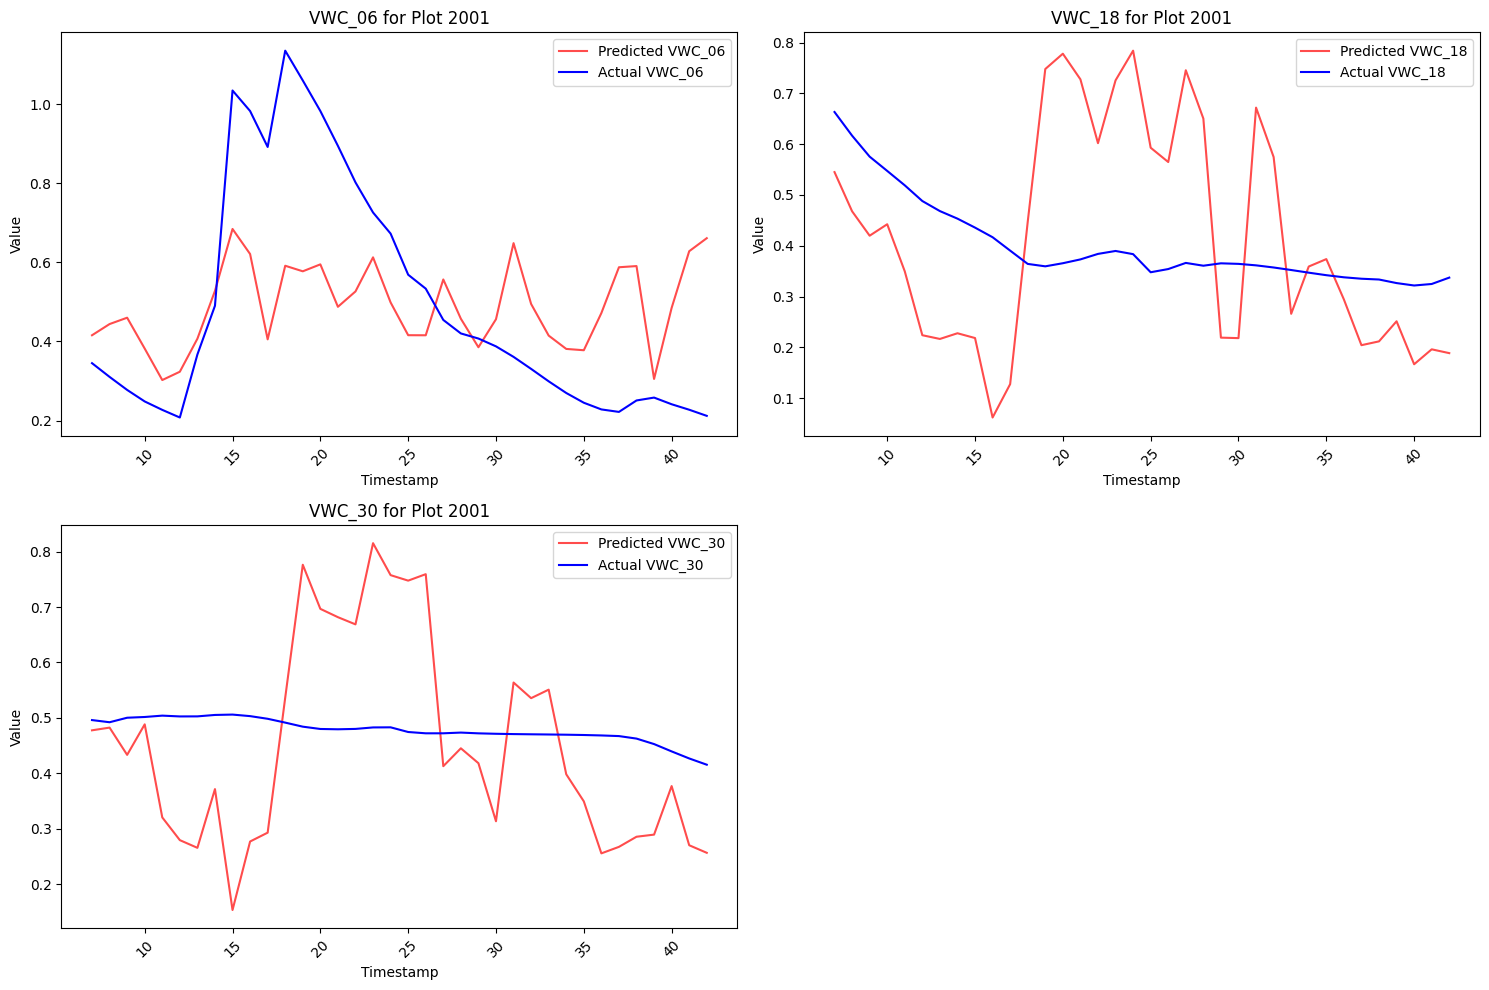

Shape of input DataFrame: (36, 3)
Mean for VWC_06:  21.204618263892556
Reversed mean for VWC_06:  7     20.293673
8     20.612255
9     20.793324
10    19.914392
11    19.018646
Name: VWC_06, dtype: float32
Mean for VWC_18:  13.365390338121223
Reversed mean for VWC_18:  7     14.122691
8     13.290953
9     12.772002
10    13.015404
11    12.014864
Name: VWC_18, dtype: float32
Mean for VWC_30:  12.371161664071709
Reversed mean for VWC_30:  7     12.122150
8     12.167868
9     11.708194
10    12.222875
11    10.653669
Name: VWC_30, dtype: float32
Shape of input DataFrame: (36, 3)
Mean for VWC_06:  21.204618263892556
Reversed mean for VWC_06:  7     19.498958
8     19.108333
9     18.737500
10    18.409375
11    18.169792
Name: VWC_06, dtype: float64
Mean for VWC_18:  13.365390338121223
Reversed mean for VWC_18:  7     15.398958
8     14.896875
9     14.451042
10    14.147917
11    13.841667
Name: VWC_18, dtype: float64
Mean for VWC_30:  12.371161664071709
Reversed mean for VWC_30:  7  

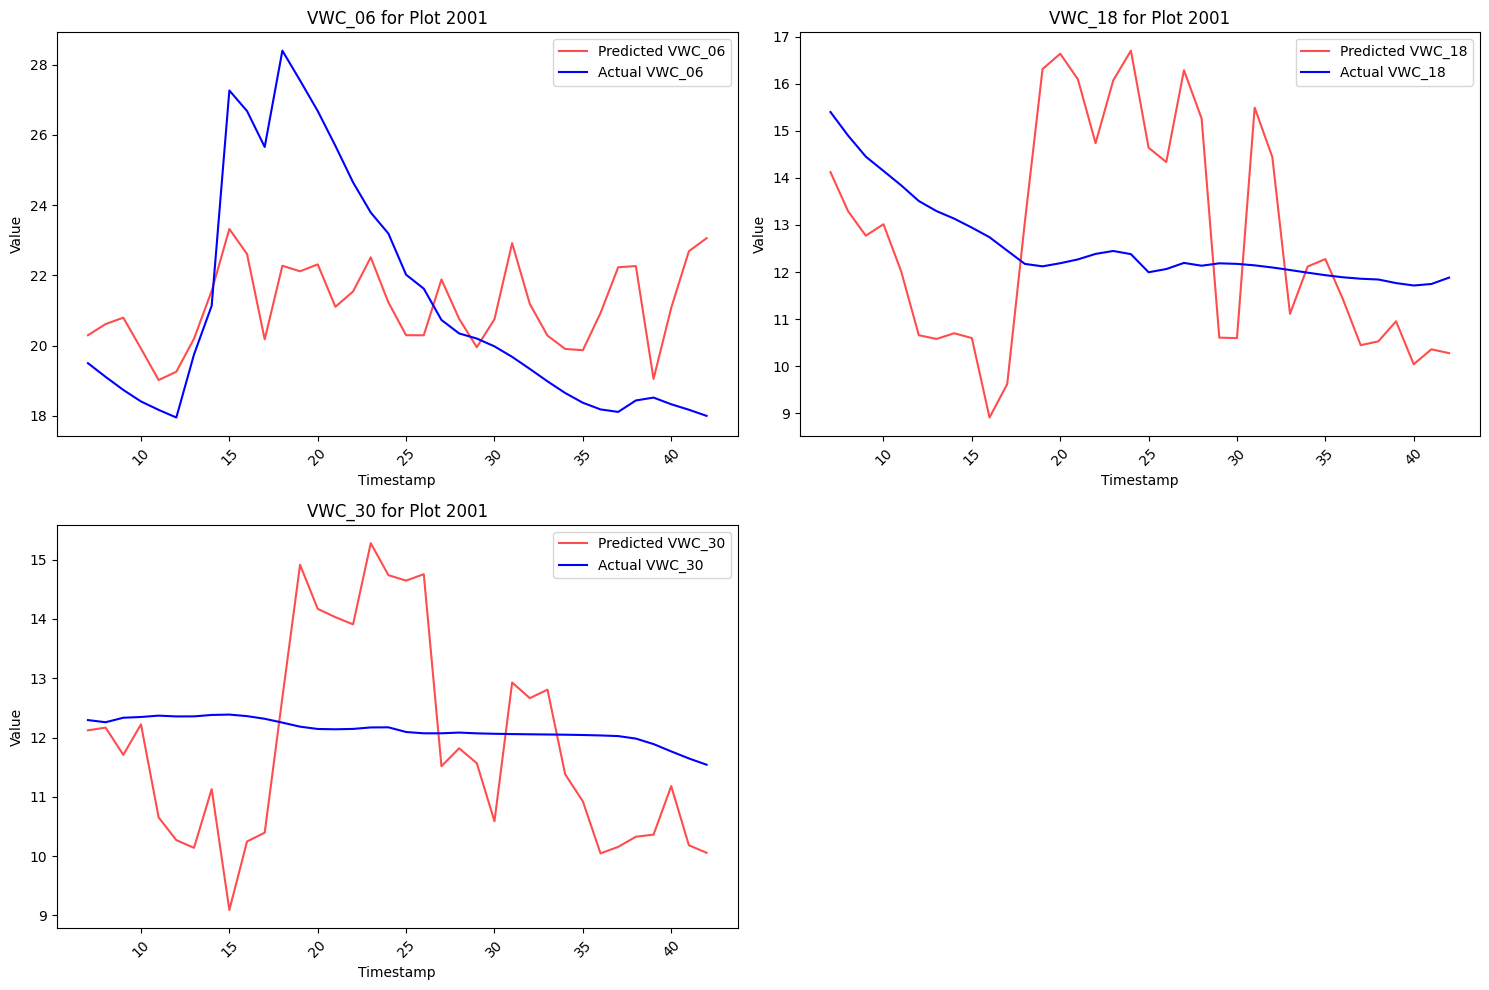

Processing plot number 2013
Shape of transformed DataFrame: (44, 21)
Mean of the transformed DataFrame: VWC_06               0.490356
VWC_18               0.472222
VWC_30               0.503526
Ta_2m_Avg            0.493860
RH_2m_Avg            0.539236
Solar_2m_Avg         0.608286
WndAveSpd_3m         0.389829
Rain_1m_Tot          0.246319
Dp_2m_Avg            0.500510
TaMax_2m             0.493925
TaMin_2m             0.493833
RHMax_2m             0.541109
RHMin_2m             0.537586
HeatIndex_2m_Avg     0.525305
irrigation           0.237216
precip_irrig         0.278760
canopy_temp          0.531296
precip_irrig_log     0.287334
VWC_06_deriv         0.343625
VWC_18_deriv         0.265045
VWC_30_deriv         0.266074
precip_irrig_bool    1.000000
dtype: float64
1/1 [==============================] - 4s 4s/step
Sequence shape: (1, 7, 22)
Sequence (top 3 lines):
[[0.78079429 0.58365241 0.52171588 0.27881149 0.77516085 0.76621909
  0.1875     0.28433099 0.5027875  0.27871066 0.2789

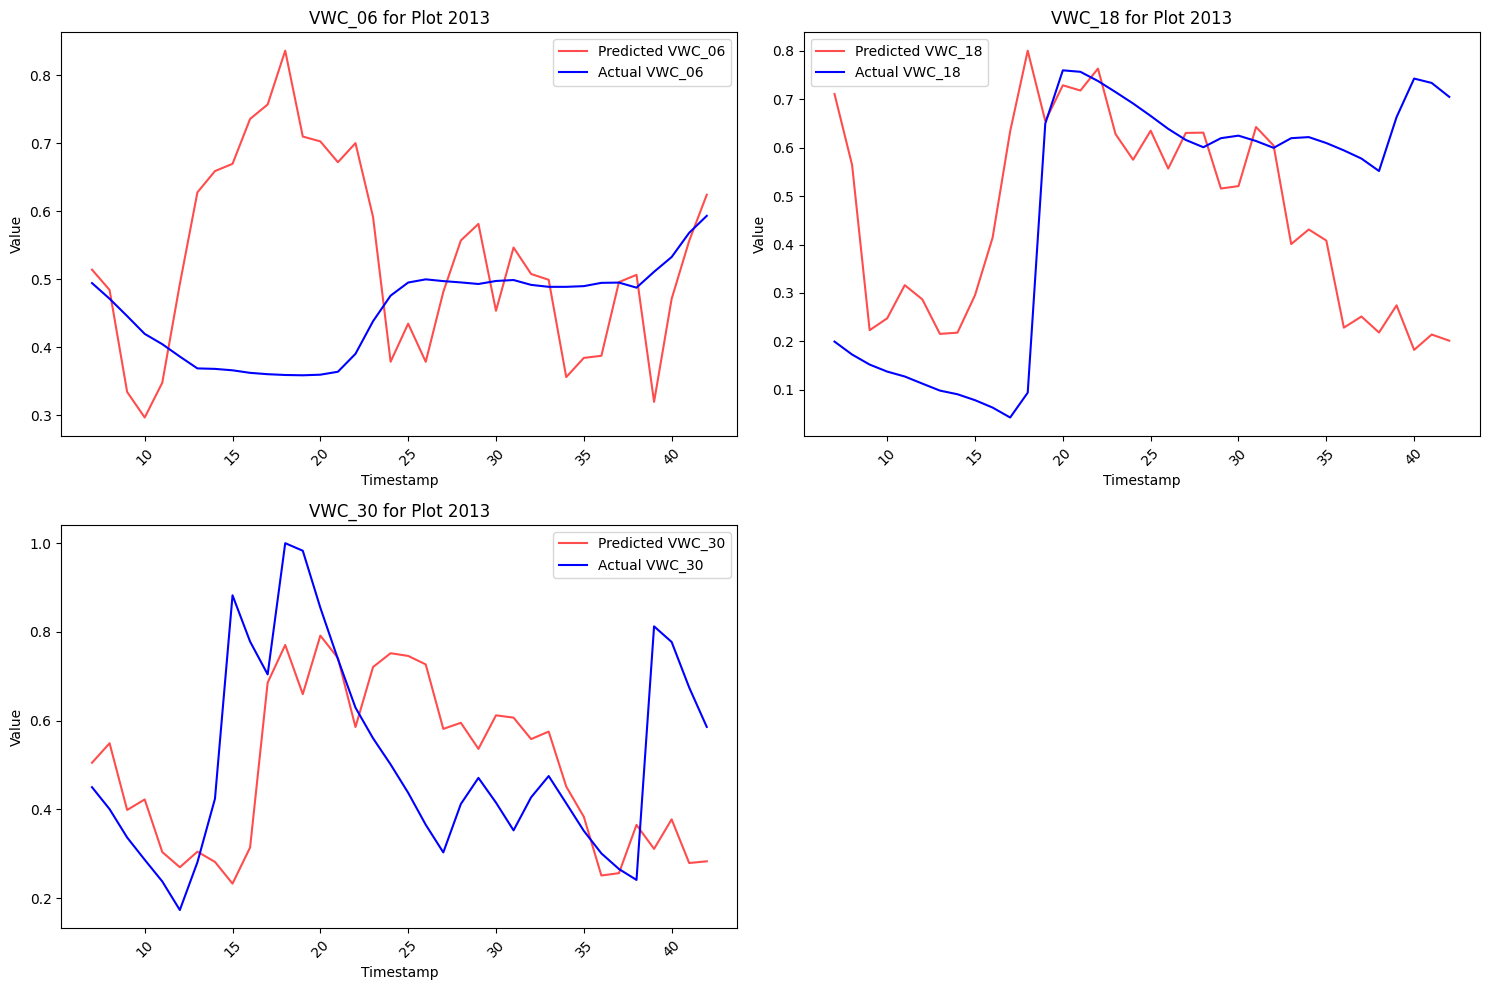

Shape of input DataFrame: (36, 3)
Mean for VWC_06:  18.350655864197527
Reversed mean for VWC_06:  7     18.542339
8     18.206621
9     16.519644
10    16.096832
11    16.672295
Name: VWC_06, dtype: float32
Mean for VWC_18:  18.555086419753085
Reversed mean for VWC_18:  7     21.104912
8     19.523129
9     15.838975
10    16.104002
11    16.843166
Name: VWC_18, dtype: float32
Mean for VWC_30:  22.856208333333335
Reversed mean for VWC_30:  7     22.864882
8     23.275637
9     21.869755
10    22.090769
11    20.982790
Name: VWC_30, dtype: float32
Shape of input DataFrame: (36, 3)
Mean for VWC_06:  18.350655864197527
Reversed mean for VWC_06:  7     18.320208
8     18.061250
9     17.774583
10    17.480000
11    17.310000
Name: VWC_06, dtype: float64
Mean for VWC_18:  18.555086419753085
Reversed mean for VWC_18:  7     15.584583
8     15.296458
9     15.072500
10    14.916042
11    14.806458
Name: VWC_18, dtype: float64
Mean for VWC_30:  22.856208333333335
Reversed mean for VWC_30:  7  

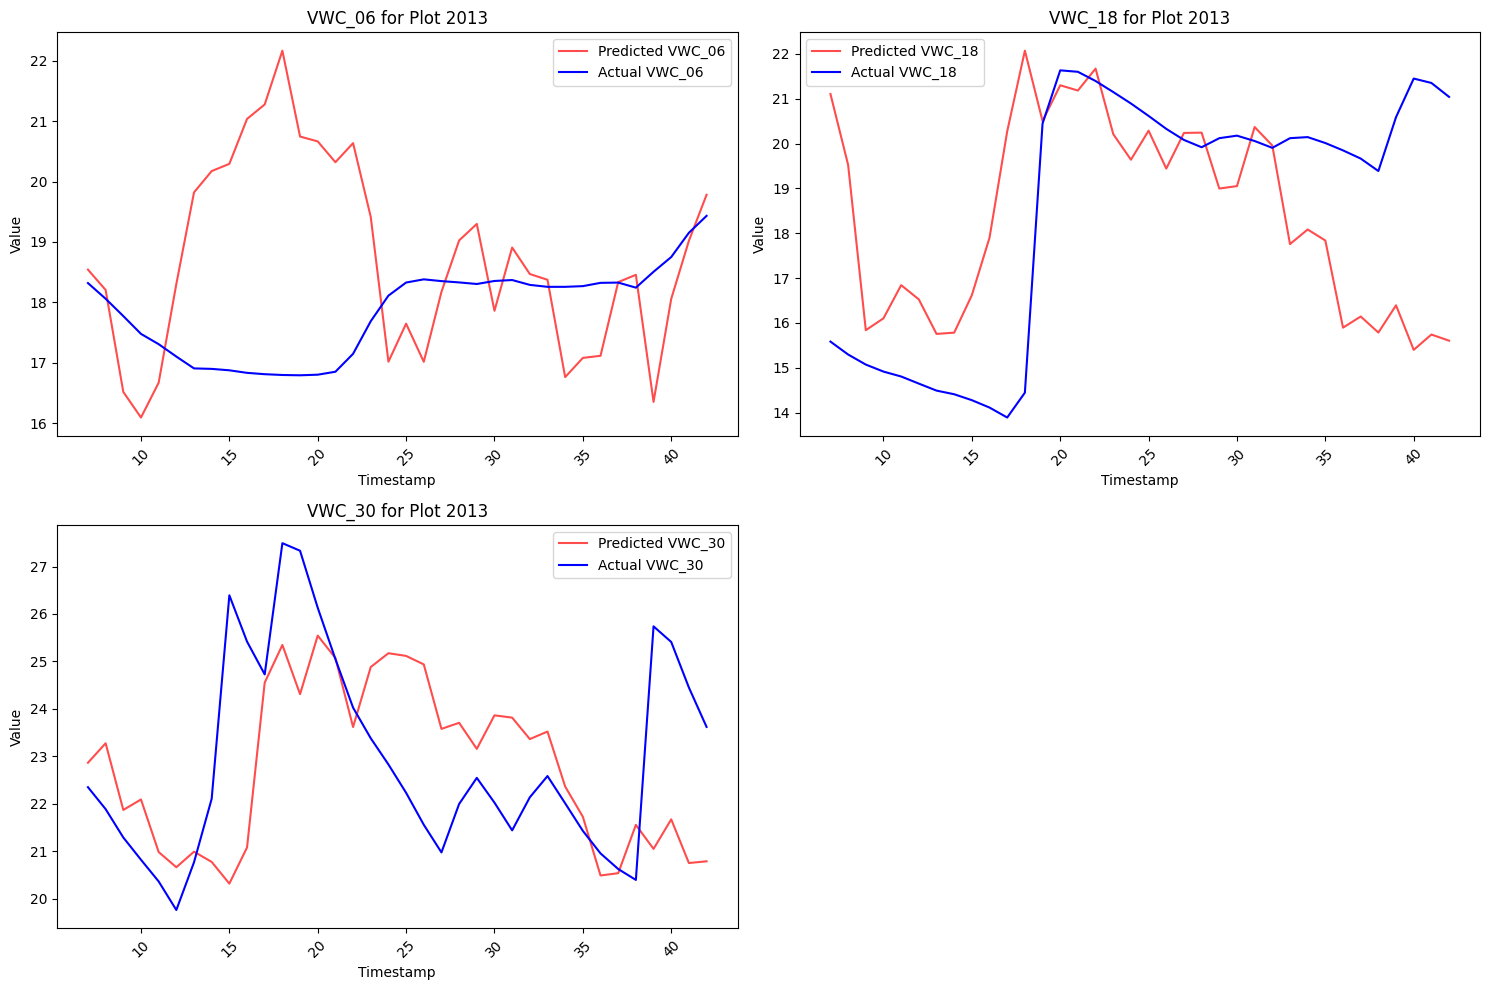

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

def plot_predictions(predictions_df, actuals_df, target_columns, plot_number):
    num_plots = len(target_columns)
    num_rows = int(np.ceil(num_plots / 2))  # You can adjust the number of columns per row if you like
    plt.figure(figsize=(15, 5 * num_rows))  # Adjust the figure size as needed
    for i, column in enumerate(target_columns):
        plt.subplot(num_rows, 2, i + 1)  # Adjust the number of columns per row if you like
        plt.plot(predictions_df.index, predictions_df[column], label=f'Predicted {column}', color='red', alpha=0.7)
        plt.plot(actuals_df.index, actuals_df[column], label=f'Actual {column}', color='blue')
        plt.legend()
        plt.title(f'{column} for Plot {plot_number}')
        plt.xlabel('Timestamp')
        plt.ylabel('Value')
        plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def predict_with_sliding_window(model, df, current_transformation_metadata, target_columns, input_window, forecast_horizon, plot_number):
    # Create input& target data, input data is all columns except target columns
    target_data = df[target_columns].values
    input_data = df.values
    predictions = []
    actuals = []
    timestamps = []
    
    # first iteration flag
    first_iter = True

    # Adjust stride based on prediction: 1 for continuous sliding
    stride = forecast_horizon
    for start in range(0, len(df) - input_window - forecast_horizon + 1, stride):
        end = start + input_window
        if end + forecast_horizon > len(input_data):
            break
        sequence = input_data[start:end]
        sequence = sequence.reshape((1, input_window, len(input_data[0])))

        

        pred = model.predict(sequence)

        
        if first_iter:
            print(f"Sequence shape: {sequence.shape}")
            # To print the top 3 lines, slice the second dimension (sequence length)
            print("Sequence (top 3 lines):")
            print(sequence[0, :3, :])  # Access the first element of the first dimension, then slice
            print(f"Predicted shape: {pred.shape}")
            # Similarly, for the predictions, slice the second dimension
            print("Predicted (top 3 lines):")
            print(pred[0, :3, :])  # Access the first element of the first dimension, then slice
        
            first_iter = False


        pred = pred.reshape(-1, pred.shape[-1])
        predictions.append(pred)
        actuals.append(target_data[end:end + forecast_horizon])
        timestamp_series = pd.Series(df.index[end:end + forecast_horizon], index=df.index[end:end + forecast_horizon])
        timestamps.append(timestamp_series)

    predictions = np.concatenate(predictions)
    actuals = np.concatenate(actuals)
    timestamps = pd.concat(timestamps)

    # Create the DataFrame with the reshaped predictions and the correct timestamps
    predictions_df = pd.DataFrame(predictions, columns=target_columns, index=timestamps)
    actuals_df = pd.DataFrame(actuals, columns=target_columns, index=timestamps)

    # Apply reverse transformation and scaling to both predictions and actuals

    # Plot the predictions and actuals before reverse transformation and scaling
    print("Plotting predictions and actuals before reverse transformation and scaling")
    print("Values of predictions_df  and actuals_df before reverse transformation and scaling")
    print(predictions_df.head(3))
    print(actuals_df.head(3))

    plot_predictions(predictions_df, actuals_df, target_columns, plot_number)

    # Apply reverse transformation and scaling to both predictions and actuals
    predictions_df = reverse_transform_and_scale_data(predictions_df, current_transformation_metadata, target_columns)
    actuals_df = reverse_transform_and_scale_data(actuals_df, current_transformation_metadata, target_columns)

    # Example usage
    print("Values of predictions_df  and actuals_df after reverse transformation and scaling")
    print(predictions_df.head(3))
    print(actuals_df.head(3))
    print("Plotting predictions and actuals after reverse transformation and scaling")
    plot_predictions(predictions_df, actuals_df, target_columns, plot_number)

    return predictions_df, actuals_df, timestamps

# Array of plot numbers
plot_numbers = [2001, 2013]

# initialize predictions_df and actuals_df and timestamps as empty dataframes
predictions_df = pd.DataFrame()
actuals_df = pd.DataFrame()
timestamps = pd.Series()

print(f"Transformation metadada {transformation_metadata}")

# initialize scalers from transformation_metadata
scalers = transformation_metadata['scalers']
keep_original_cols = transformation_metadata['keep_original_cols'] 

# Loop through plot numbers
for plot_number in plot_numbers:
    print(f"Processing plot number {plot_number}")
    
    model = tf.keras.models.load_model(checkpoint_path)
    

    df_plot = process_data_for_plot(plot_number, target_columns, continuous_columns)
    
    #drop VWC_40 column if it exists
    if 'VWC_42' in df_plot.columns:
        df_plot = df_plot.drop(columns=['VWC_42'])

    df_plot, current_transform_metadata = transform_and_scale_data(df_plot, target_columns, scalers, keep_original_cols)
    
    # print the mean of the transformed dataframe
    print(f"Mean of the transformed DataFrame: {df_plot.mean()}")

    
    predictions_df, actuals_df, timestamps = predict_with_sliding_window(model, df_plot, current_transformation_metadata=current_transform_metadata, 
                                                                         target_columns=target_columns, input_window=7, forecast_horizon=4, plot_number=plot_number)


In [ ]:
# verify column equivalence across all dataframes
for df in training_data_transformed():
    # Verify column equivalence across all dataframes
    first_df = training_data_transformed()[0][0]  # Get the first transformed dataframe
    column_equivalence = True

    for df_tuple in training_data_transformed():
        df = df_tuple[0]  # Get the transformed dataframe
        if not df.columns.equals(first_df.columns):
            column_equivalence = False
            break

    if column_equivalence:
        print("All dataframes have equivalent columns.")
    else:
        print("Dataframes have different columns.")